In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH =50

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss(reduction="none")(air_pr.float(), air_x.float())
        air_loss = torch.where(air_x == 1, air_loss, air_loss * 10.0)
        air_loss = air_loss.mean()
        
        _loss = _gen + air_loss + _mae + _ssim + _dis
        _loss.backward()    
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f44f4a6a250>,)

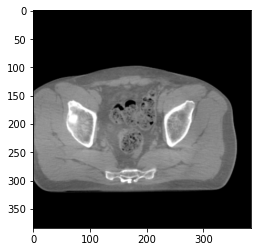

In [22]:
plt.imshow(x.squeeze(), 'gray'),

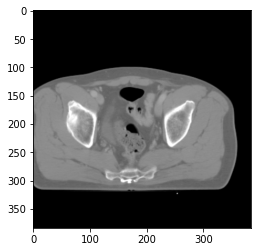

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:06,  1.32it/s]
168it [00:37,  4.50it/s]
24it [00:05,  4.26it/s]
168it [02:07,  1.32it/s]
168it [00:37,  4.48it/s]
24it [00:05,  4.24it/s]
168it [02:07,  1.32it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.23it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.23it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.23it/s]
168it [03:19,  1.19s/it]
168it [01:16,  2.19it/s]
24it [00:11,  2.08it/s]
168it [04:11,  1.50s/it]
168it [01:18,  2.15it/s]
24it [00:11,  2.05it/s]
168it [04:08,  1.48s/it]
168it [01:17,  2.16it/s]
24it [00:12,  1.89it/s]
168it [04:12,  1.50s/it]
168it [01:16,  2.19it/s]
24it [00:11,  2.05it/s]
168it [04:09,  1.49s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.06it/s]
168it [04:18,  1.54s/it]
168it [01:16,  2.20it/s]
24it [00:11,  2.06it/s]
168it [04:09,  1.49s/it]
168it [01:18,  2.14it/s]
24it [00:11,  2.06it/s]
168it [04:11,  1.50s/it]
168it [01:15,

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9031901359558105
psnr score = 26.754222869873047
snr score = 16.817161560058594
mae error = 0.015284054912626743
air dice score = 0.9939531442663438
bone dice score = 0.9527294014349081


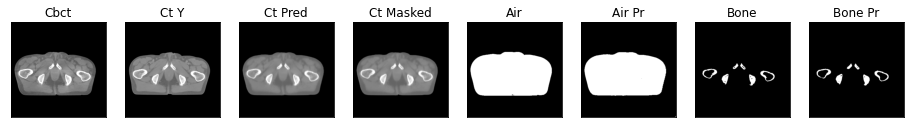

ssim score = 0.9035606980323792
psnr score = 26.675552368164062
snr score = 16.786026000976562
mae error = 0.015501913614571095
air dice score = 0.9945398277187573
bone dice score = 0.9538904899142091


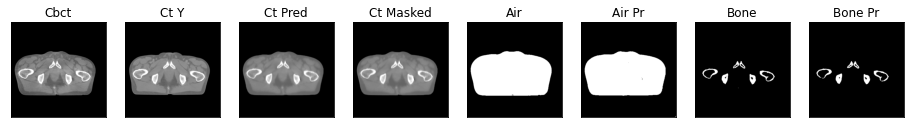

ssim score = 0.9029178619384766
psnr score = 26.568288803100586
snr score = 16.841657638549805
mae error = 0.016552696004509926
air dice score = 0.9945484478356504
bone dice score = 0.9422492401222826


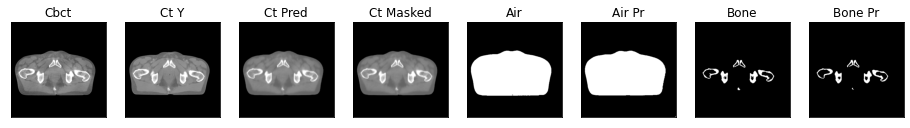

ssim score = 0.9016357064247131
psnr score = 26.711772918701172
snr score = 17.07439613342285
mae error = 0.016436195001006126
air dice score = 0.9955146317848649
bone dice score = 0.9299432562207558


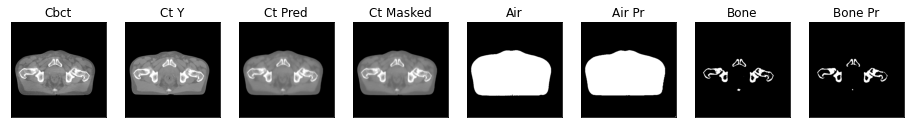

ssim score = 0.9009512066841125
psnr score = 26.864986419677734
snr score = 17.26791000366211
mae error = 0.016248872503638268
air dice score = 0.9953105636246514
bone dice score = 0.93054605841623


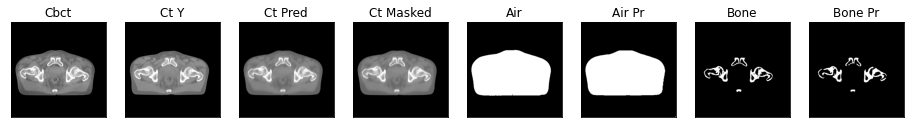

ssim score = 0.8961800336837769
psnr score = 26.679424285888672
snr score = 17.218883514404297
mae error = 0.01697261445224285
air dice score = 0.9953295691054528
bone dice score = 0.9249209255874403


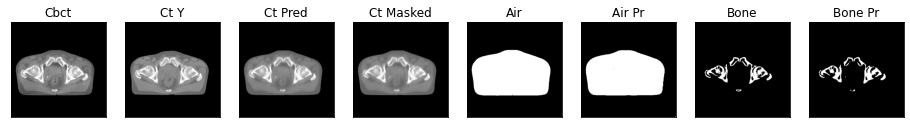

ssim score = 0.8938891291618347
psnr score = 26.613378524780273
snr score = 17.128782272338867
mae error = 0.01743767224252224
air dice score = 0.9950493065020494
bone dice score = 0.9337779895193443


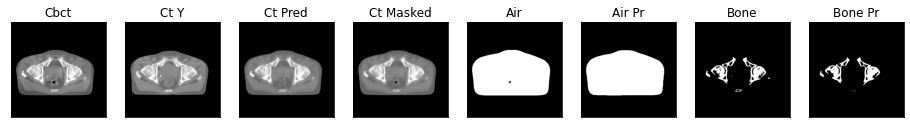

ssim score = 0.8950421810150146
psnr score = 26.939186096191406
snr score = 17.269054412841797
mae error = 0.016884058713912964
air dice score = 0.9953531504833375
bone dice score = 0.9396431070684076


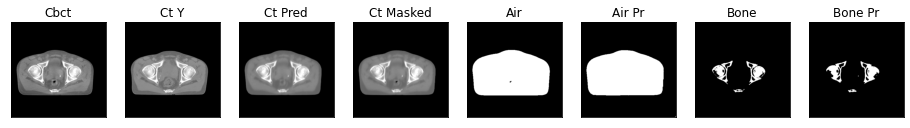

1it [00:03,  3.05s/it]

ssim score = 0.8984411358833313
psnr score = 27.21967887878418
snr score = 17.45499038696289
mae error = 0.016128497198224068
air dice score = 0.9952247219490483
bone dice score = 0.9513802655463618


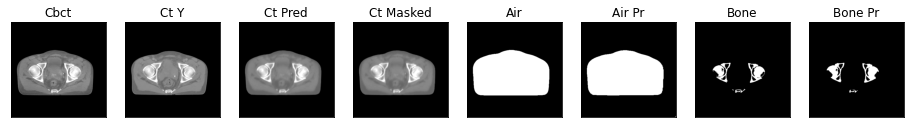

ssim score = 0.9028792977333069
psnr score = 27.491561889648438
snr score = 17.711589813232422
mae error = 0.015711525455117226
air dice score = 0.9948769237049487
bone dice score = 0.9467620182762538


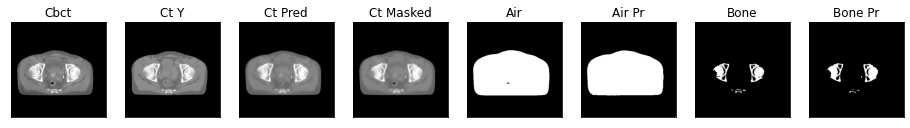

ssim score = 0.908149778842926
psnr score = 27.740381240844727
snr score = 17.99267578125
mae error = 0.015246478840708733
air dice score = 0.9948451491004735
bone dice score = 0.9558376167003478


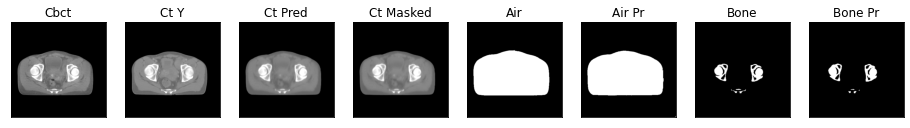

ssim score = 0.9084897637367249
psnr score = 27.50373649597168
snr score = 17.779743194580078
mae error = 0.015594959259033203
air dice score = 0.9921620194448264
bone dice score = 0.9603208104689709


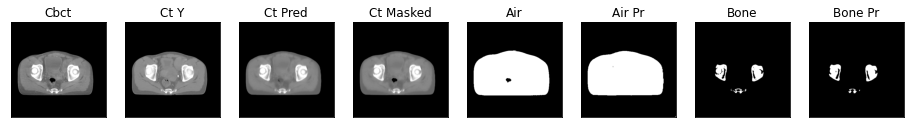

ssim score = 0.9128720164299011
psnr score = 26.651020050048828
snr score = 16.895105361938477
mae error = 0.016082027927041054
air dice score = 0.9910765657854912
bone dice score = 0.9609616485408018


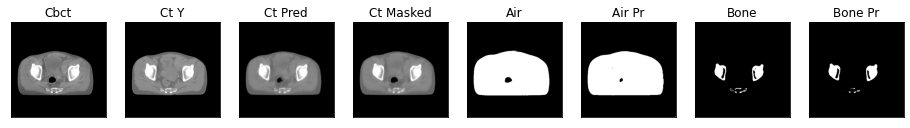

ssim score = 0.9090850353240967
psnr score = 26.1403751373291
snr score = 16.242502212524414
mae error = 0.016795510426163673
air dice score = 0.9914764336048024
bone dice score = 0.9415584415591713


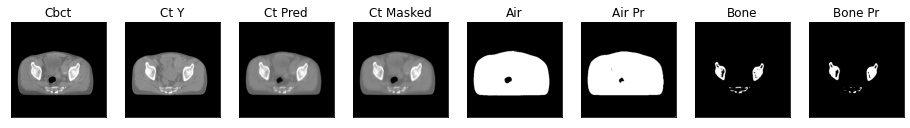

ssim score = 0.9082222580909729
psnr score = 26.88699722290039
snr score = 16.903465270996094
mae error = 0.01634438894689083
air dice score = 0.9902503572751916
bone dice score = 0.9305926321418768


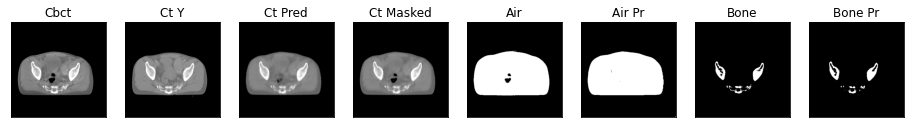

ssim score = 0.9011646509170532
psnr score = 26.39632797241211
snr score = 16.436275482177734
mae error = 0.01703009195625782
air dice score = 0.9912364869187069
bone dice score = 0.9354103343473226


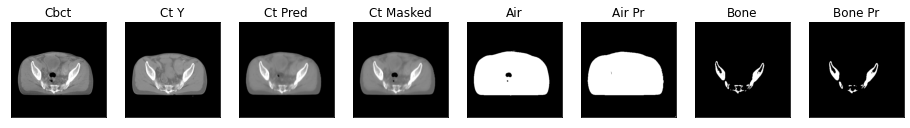

2it [00:05,  2.83s/it]

ssim score = 0.8959468603134155
psnr score = 25.416109085083008
snr score = 15.453516006469727
mae error = 0.01820135861635208
air dice score = 0.988973834392173
bone dice score = 0.9317855433229799


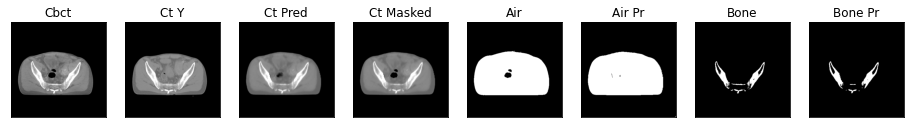

ssim score = 0.8922059535980225
psnr score = 25.283767700195312
snr score = 15.219415664672852
mae error = 0.01858931966125965
air dice score = 0.9867130208050554
bone dice score = 0.9243191130401985


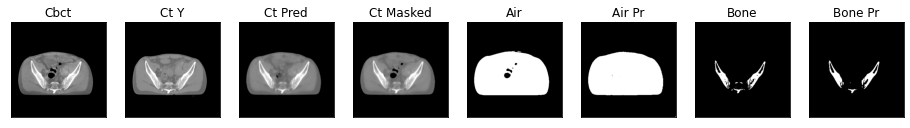

ssim score = 0.8921393156051636
psnr score = 25.039081573486328
snr score = 14.92404556274414
mae error = 0.018790461122989655
air dice score = 0.9868214931259387
bone dice score = 0.912446758164784


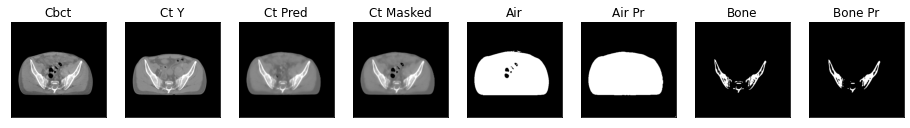

ssim score = 0.8907855153083801
psnr score = 24.40891456604004
snr score = 14.281572341918945
mae error = 0.019762620329856873
air dice score = 0.9885910561832626
bone dice score = 0.9144105863795748


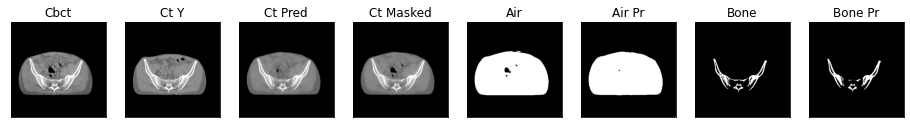

ssim score = 0.8855067491531372
psnr score = 23.92095184326172
snr score = 13.728759765625
mae error = 0.02062169648706913
air dice score = 0.9889455308041664
bone dice score = 0.8972768940429054


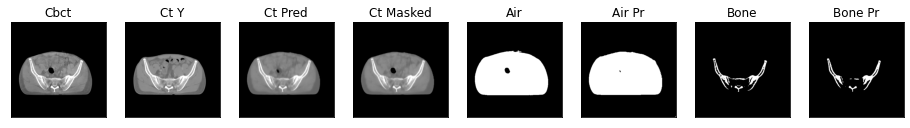

ssim score = 0.8846595883369446
psnr score = 23.82205581665039
snr score = 13.5704345703125
mae error = 0.020239032804965973
air dice score = 0.9900963356441995
bone dice score = 0.9138586600247298


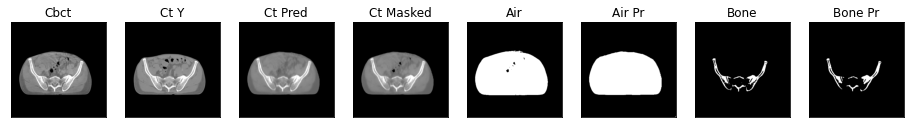

ssim score = 0.8868094682693481
psnr score = 23.766565322875977
snr score = 13.48151683807373
mae error = 0.020094139501452446
air dice score = 0.9910704116266987
bone dice score = 0.9234718826415224


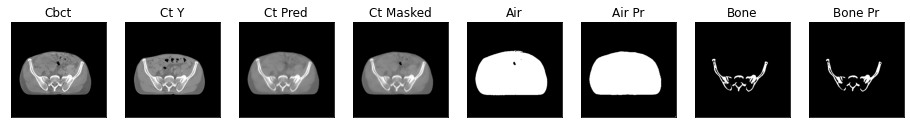

ssim score = 0.8874511122703552
psnr score = 23.67420196533203
snr score = 13.34058666229248
mae error = 0.020279476419091225
air dice score = 0.9916074738381225
bone dice score = 0.9131308355996556


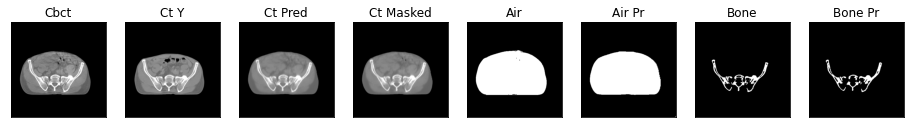

3it [00:07,  2.74s/it]

ssim score = 0.8867383003234863
psnr score = 23.542640686035156
snr score = 13.112028121948242
mae error = 0.020482318475842476
air dice score = 0.9915452167414149
bone dice score = 0.9186602870822662


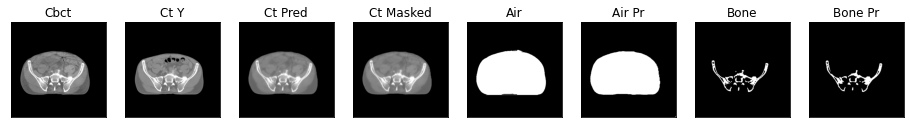

ssim score = 0.8885696530342102
psnr score = 23.787574768066406
snr score = 13.274227142333984
mae error = 0.0196253452450037
air dice score = 0.9924924924925015
bone dice score = 0.9050074481505097


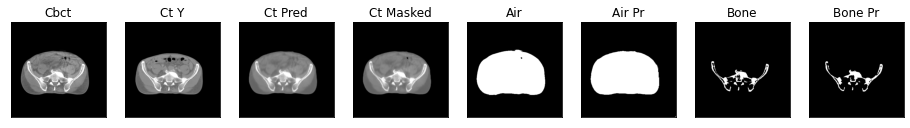

ssim score = 0.8891761302947998
psnr score = 23.97210121154785
snr score = 13.36756706237793
mae error = 0.01945233903825283
air dice score = 0.9918343540390884
bone dice score = 0.9128593715186889


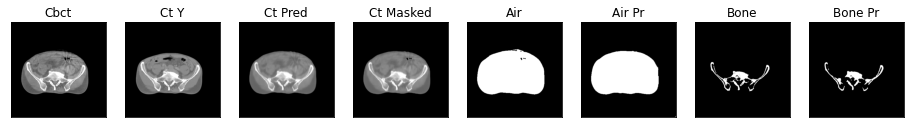

ssim score = 0.8901053667068481
psnr score = 23.82129669189453
snr score = 13.175655364990234
mae error = 0.019748907536268234
air dice score = 0.9910577917919015
bone dice score = 0.9124287824444774


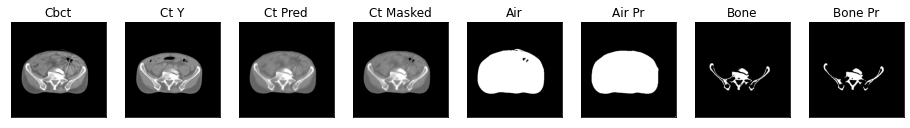

ssim score = 0.8760080933570862
psnr score = 24.069408416748047
snr score = 15.441568374633789
mae error = 0.02114960551261902
air dice score = 0.9926426111323758
bone dice score = 0.9784946236565941


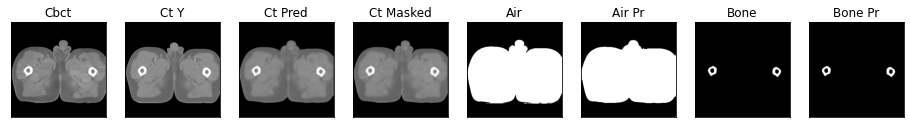

ssim score = 0.8800731897354126
psnr score = 24.64870262145996
snr score = 16.060117721557617
mae error = 0.019964799284934998
air dice score = 0.9924462521789703
bone dice score = 0.9745260663514654


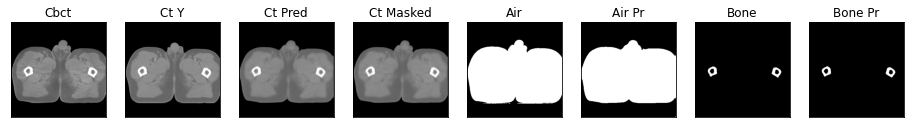

ssim score = 0.8887047171592712
psnr score = 25.300180435180664
snr score = 16.79904556274414
mae error = 0.01880837045609951
air dice score = 0.9932214312203289
bone dice score = 0.9594113458352858


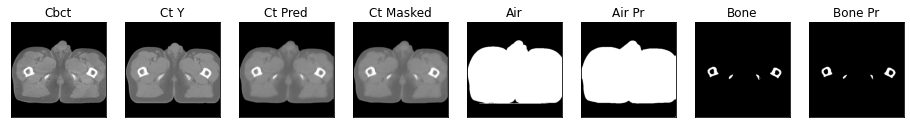

ssim score = 0.8944529891014099
psnr score = 25.8054141998291
snr score = 17.466833114624023
mae error = 0.018542757257819176
air dice score = 0.9943220641322589
bone dice score = 0.9690621978735247


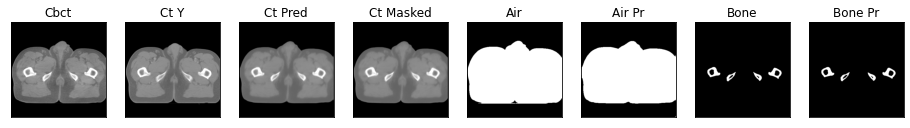

4it [00:10,  2.68s/it]

ssim score = 0.8960740566253662
psnr score = 26.165149688720703
snr score = 17.954710006713867
mae error = 0.018176570534706116
air dice score = 0.994948491471443
bone dice score = 0.9551407077186522


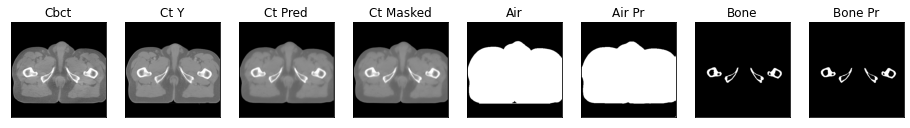

ssim score = 0.8990792036056519
psnr score = 26.81192398071289
snr score = 18.704727172851562
mae error = 0.01749141700565815
air dice score = 0.9948630548020867
bone dice score = 0.9494900437111523


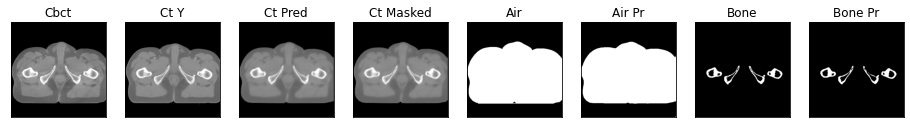

ssim score = 0.9015992283821106
psnr score = 27.253936767578125
snr score = 19.213842391967773
mae error = 0.017331156879663467
air dice score = 0.9948762712168439
bone dice score = 0.9498785603891601


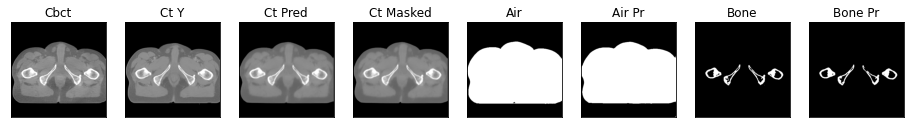

ssim score = 0.9008777737617493
psnr score = 27.328907012939453
snr score = 19.278921127319336
mae error = 0.01716211996972561
air dice score = 0.9952760220889184
bone dice score = 0.9608799418910358


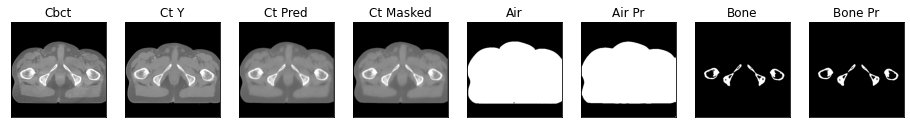

ssim score = 0.9033149480819702
psnr score = 27.351598739624023
snr score = 19.287948608398438
mae error = 0.017107469961047173
air dice score = 0.9950603634288597
bone dice score = 0.9598513778515858


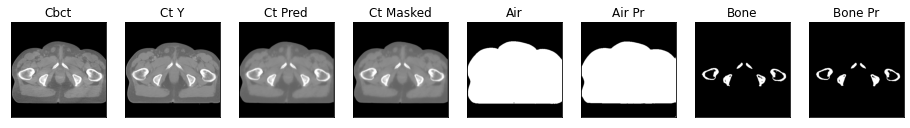

ssim score = 0.9055567383766174
psnr score = 27.4520206451416
snr score = 19.40036964416504
mae error = 0.017305677756667137
air dice score = 0.9953334283271615
bone dice score = 0.9532259831311948


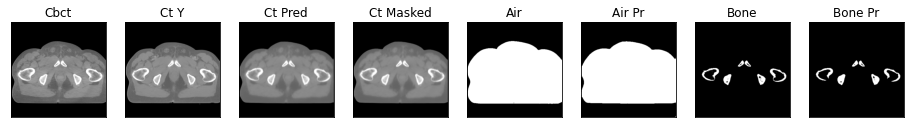

ssim score = 0.9067052006721497
psnr score = 27.429485321044922
snr score = 19.416919708251953
mae error = 0.017138952389359474
air dice score = 0.9954057102154713
bone dice score = 0.950993676603986


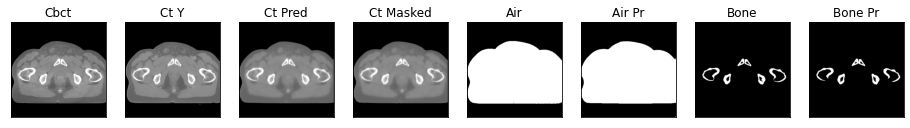

ssim score = 0.9063166379928589
psnr score = 27.42055892944336
snr score = 19.54928207397461
mae error = 0.017573218792676926
air dice score = 0.9955122877834527
bone dice score = 0.9505696080329159


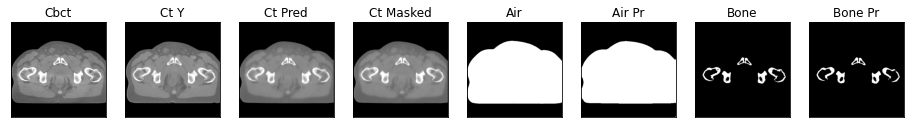

5it [00:12,  2.58s/it]

ssim score = 0.9055838584899902
psnr score = 27.452600479125977
snr score = 19.67601203918457
mae error = 0.017940351739525795
air dice score = 0.9957028487200696
bone dice score = 0.9516592214426319


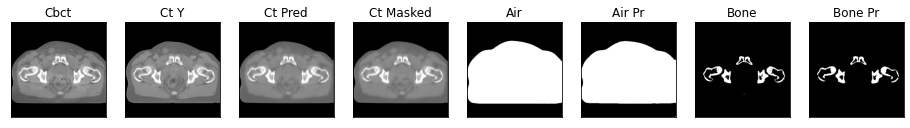

ssim score = 0.8952845931053162
psnr score = 26.783979415893555
snr score = 18.973342895507812
mae error = 0.019602155312895775
air dice score = 0.9955957638280527
bone dice score = 0.9238170347009163


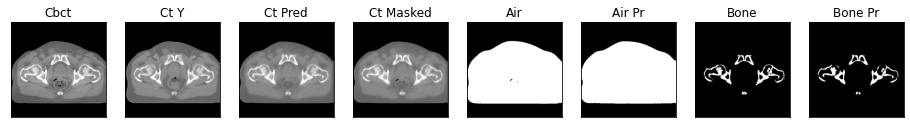

ssim score = 0.8936770558357239
psnr score = 26.722774505615234
snr score = 18.984325408935547
mae error = 0.019954703748226166
air dice score = 0.9938720796629681
bone dice score = 0.911016086337399


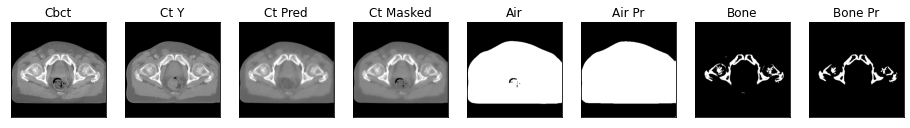

ssim score = 0.8898785710334778
psnr score = 26.51348304748535
snr score = 18.638938903808594
mae error = 0.020135361701250076
air dice score = 0.9945397862767863
bone dice score = 0.8958111466107933


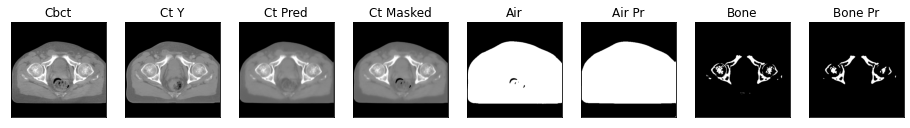

ssim score = 0.8905746936798096
psnr score = 26.409252166748047
snr score = 18.356143951416016
mae error = 0.019475901499390602
air dice score = 0.9948471936792274
bone dice score = 0.8840844498590734


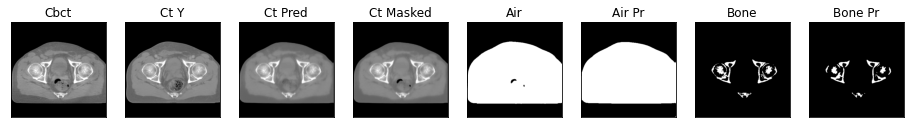

ssim score = 0.8899455666542053
psnr score = 26.01677703857422
snr score = 17.87308120727539
mae error = 0.020074987784028053
air dice score = 0.9962641454686162
bone dice score = 0.8651943869350678


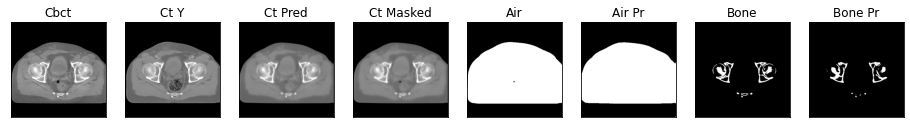

ssim score = 0.8900434374809265
psnr score = 25.83362579345703
snr score = 17.70561981201172
mae error = 0.020211150869727135
air dice score = 0.9965498809465981
bone dice score = 0.8942540853991118


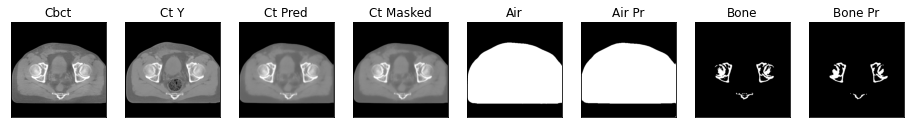

ssim score = 0.8807240128517151
psnr score = 25.815479278564453
snr score = 17.697511672973633
mae error = 0.020908020436763763
air dice score = 0.9965683161545622
bone dice score = 0.9139182361055221


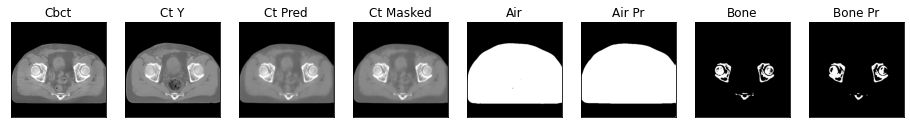

6it [00:15,  2.57s/it]

ssim score = 0.8871484994888306
psnr score = 26.28897476196289
snr score = 18.232595443725586
mae error = 0.019738340750336647
air dice score = 0.9964584201367636
bone dice score = 0.941954179118519


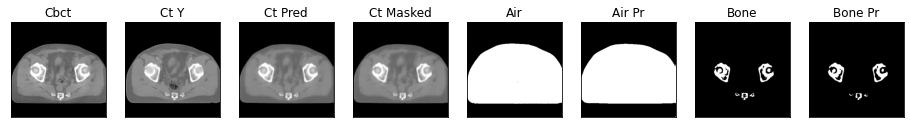

ssim score = 0.889799177646637
psnr score = 27.091815948486328
snr score = 19.105518341064453
mae error = 0.018975982442498207
air dice score = 0.9963277738203457
bone dice score = 0.9573319400909324


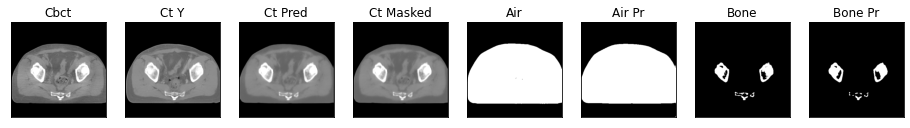

ssim score = 0.8934009671211243
psnr score = 26.678985595703125
snr score = 18.57358169555664
mae error = 0.019164877012372017
air dice score = 0.9960758786285865
bone dice score = 0.9475637144815198


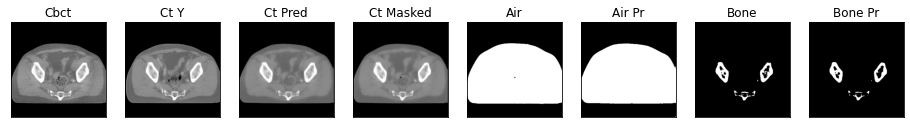

ssim score = 0.8880211710929871
psnr score = 26.126121520996094
snr score = 18.10234832763672
mae error = 0.0207710899412632
air dice score = 0.9953272174254346
bone dice score = 0.9545569513535574


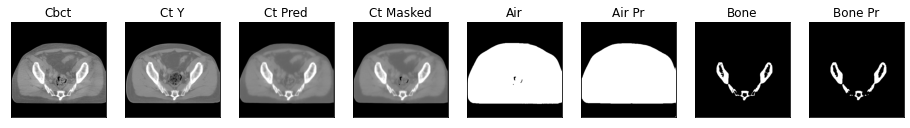

ssim score = 0.8880963325500488
psnr score = 26.29573631286621
snr score = 18.35210609436035
mae error = 0.020390266552567482
air dice score = 0.9940751701325021
bone dice score = 0.9558977217309559


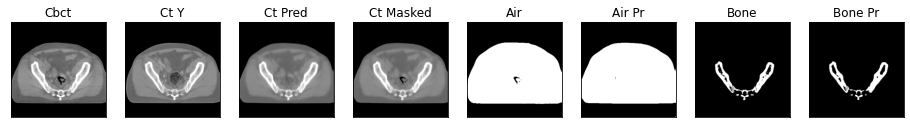

ssim score = 0.873100996017456
psnr score = 25.77458953857422
snr score = 17.85251808166504
mae error = 0.022403035312891006
air dice score = 0.9933614966807524
bone dice score = 0.9436131892494901


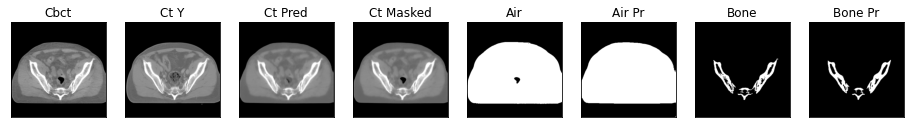

ssim score = 0.873888373374939
psnr score = 25.844024658203125
snr score = 17.934492111206055
mae error = 0.02269935794174671
air dice score = 0.9954377737790165
bone dice score = 0.9528550095999939


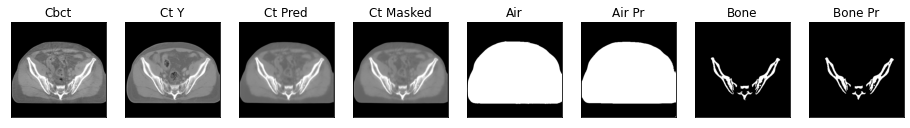

ssim score = 0.82271409034729
psnr score = 21.192291259765625
snr score = 11.072497367858887
mae error = 0.032396819442510605
air dice score = 0.9955870792539167
bone dice score = 0.9570552147251239


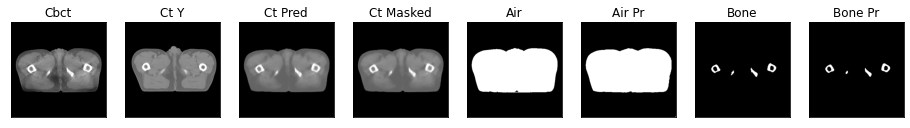

7it [00:17,  2.56s/it]

ssim score = 0.8121017217636108
psnr score = 20.844650268554688
snr score = 10.937838554382324
mae error = 0.03493102267384529
air dice score = 0.9953376848274985
bone dice score = 0.9218427687388988


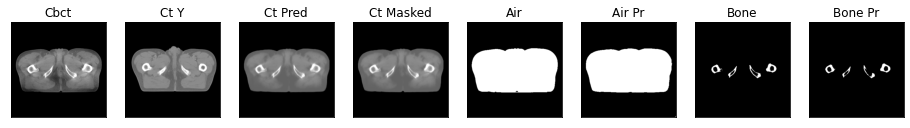

ssim score = 0.8071325421333313
psnr score = 20.846736907958984
snr score = 11.071063041687012
mae error = 0.03545311093330383
air dice score = 0.9950447386784247
bone dice score = 0.8696043165496942


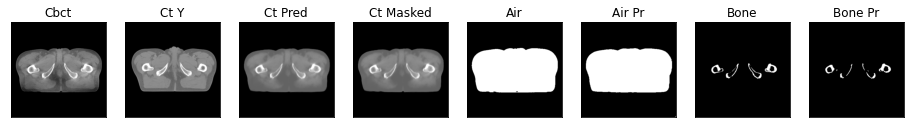

ssim score = 0.8097145557403564
psnr score = 21.117481231689453
snr score = 11.412210464477539
mae error = 0.034486450254917145
air dice score = 0.9945929787851394
bone dice score = 0.8736979166694075


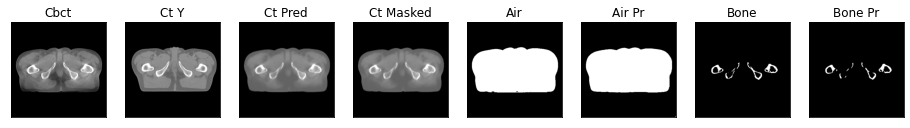

ssim score = 0.8114690184593201
psnr score = 21.161865234375
snr score = 11.504162788391113
mae error = 0.03436761349439621
air dice score = 0.9935655802373954
bone dice score = 0.8747920133137522


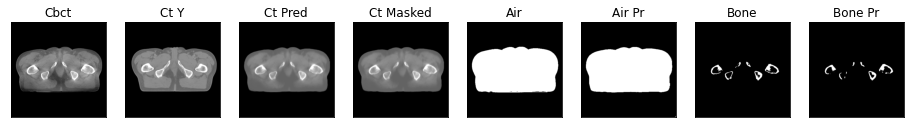

ssim score = 0.8117645978927612
psnr score = 21.2904052734375
snr score = 11.638318061828613
mae error = 0.03377086669206619
air dice score = 0.9930872958305356
bone dice score = 0.8937757706677052


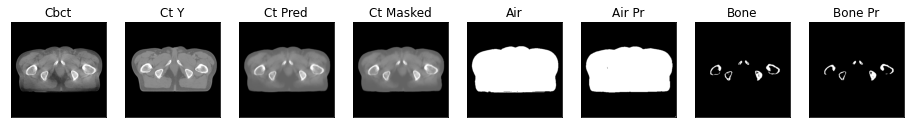

ssim score = 0.8131462931632996
psnr score = 21.355491638183594
snr score = 11.696900367736816
mae error = 0.03332773223519325
air dice score = 0.9930547688553936
bone dice score = 0.9153010858851865


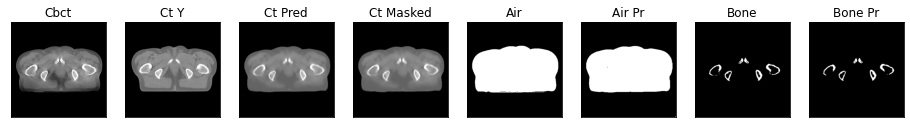

ssim score = 0.8121883869171143
psnr score = 21.169015884399414
snr score = 11.524535179138184
mae error = 0.033845581114292145
air dice score = 0.9933413780829825
bone dice score = 0.9211428571443592


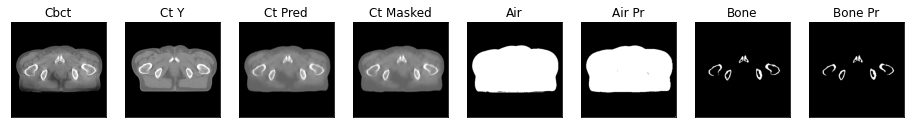

ssim score = 0.8109421133995056
psnr score = 21.083709716796875
snr score = 11.497235298156738
mae error = 0.03507595509290695
air dice score = 0.993720619611794
bone dice score = 0.8918871561259526


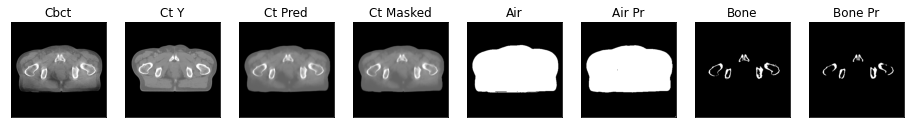

8it [00:20,  2.49s/it]

ssim score = 0.8034953474998474
psnr score = 20.908823013305664
snr score = 11.420907974243164
mae error = 0.03697371110320091
air dice score = 0.9931256323121281
bone dice score = 0.8411149825811652


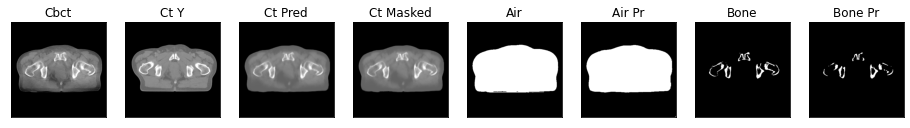

ssim score = 0.7925397157669067
psnr score = 20.744382858276367
snr score = 11.292299270629883
mae error = 0.03804893419146538
air dice score = 0.9933073688028452
bone dice score = 0.8499344692029828


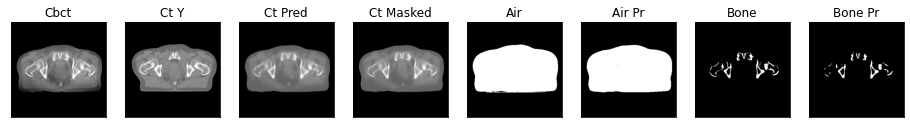

ssim score = 0.7811296582221985
psnr score = 20.677701950073242
snr score = 11.258321762084961
mae error = 0.03807298094034195
air dice score = 0.9938502143368548
bone dice score = 0.8363056401357647


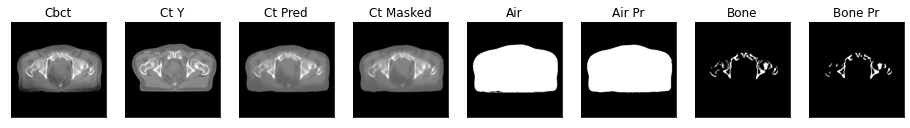

ssim score = 0.7827699780464172
psnr score = 20.627857208251953
snr score = 11.32529354095459
mae error = 0.03884108364582062
air dice score = 0.9945150663194072
bone dice score = 0.8267530936973077


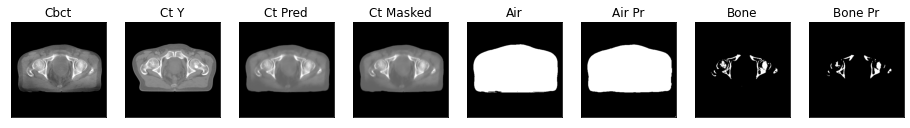

ssim score = 0.7855139374732971
psnr score = 20.537126541137695
snr score = 11.218576431274414
mae error = 0.03912373632192612
air dice score = 0.9945877932330226
bone dice score = 0.829773462785926


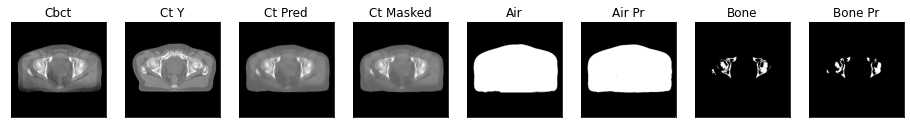

ssim score = 0.8015746474266052
psnr score = 21.133089065551758
snr score = 11.615377426147461
mae error = 0.03544546663761139
air dice score = 0.9946966044493468
bone dice score = 0.8684210526337985


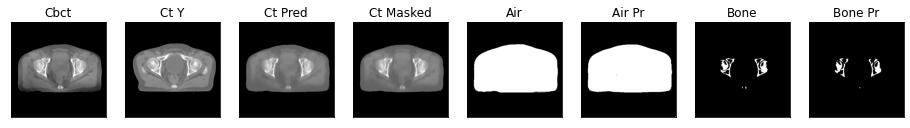

ssim score = 0.8190225958824158
psnr score = 21.90520477294922
snr score = 12.21710205078125
mae error = 0.031744010746479034
air dice score = 0.9949190574034793
bone dice score = 0.9164684898942261


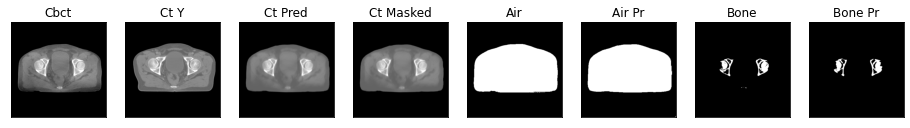

ssim score = 0.826267421245575
psnr score = 22.259807586669922
snr score = 12.585872650146484
mae error = 0.03034619428217411
air dice score = 0.9951685017206354
bone dice score = 0.9400162118354497


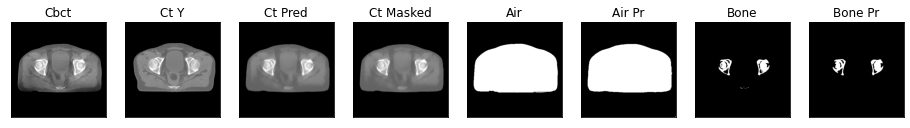

9it [00:22,  2.50s/it]

ssim score = 0.8310444951057434
psnr score = 22.43994903564453
snr score = 12.8478422164917
mae error = 0.029949631541967392
air dice score = 0.9954186183923244
bone dice score = 0.9532685035122465


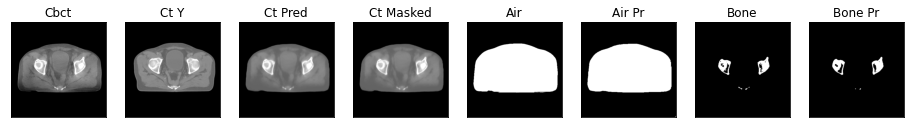

ssim score = 0.8318951725959778
psnr score = 22.4112491607666
snr score = 12.91131591796875
mae error = 0.030225668102502823
air dice score = 0.995765027322408
bone dice score = 0.9402869927489541


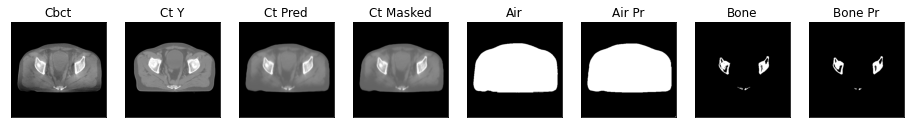

ssim score = 0.8283960223197937
psnr score = 22.675201416015625
snr score = 13.111839294433594
mae error = 0.029315778985619545
air dice score = 0.9953376780275355
bone dice score = 0.9516728624543482


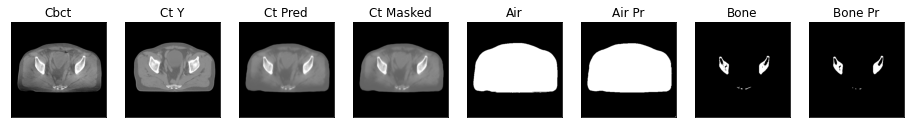

ssim score = 0.8326916098594666
psnr score = 23.050260543823242
snr score = 13.450504302978516
mae error = 0.027704549953341484
air dice score = 0.9942255434782657
bone dice score = 0.9476372924658341


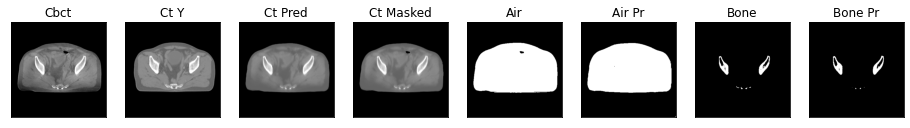

ssim score = 0.8283668160438538
psnr score = 22.834270477294922
snr score = 13.272260665893555
mae error = 0.028969138860702515
air dice score = 0.9939379531677218
bone dice score = 0.9138551121782179


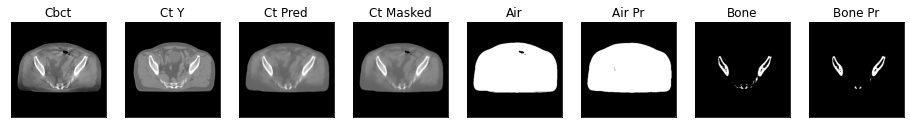

ssim score = 0.8216496109962463
psnr score = 22.623491287231445
snr score = 13.191987037658691
mae error = 0.030119869858026505
air dice score = 0.9948411990175375
bone dice score = 0.9205191774840233


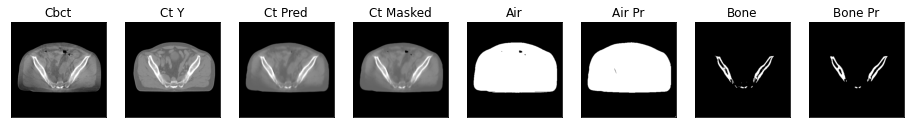

ssim score = 0.8240129947662354
psnr score = 22.680450439453125
snr score = 13.266693115234375
mae error = 0.0299848485738039
air dice score = 0.9950377709189545
bone dice score = 0.892248311355866


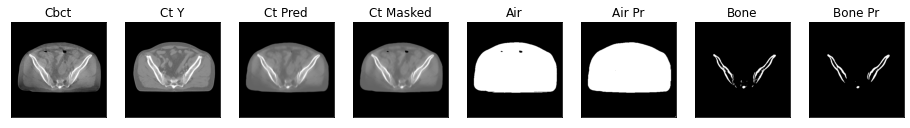

ssim score = 0.8266758918762207
psnr score = 22.9497127532959
snr score = 13.524688720703125
mae error = 0.0292699933052063
air dice score = 0.9957748048096984
bone dice score = 0.9031693223620527


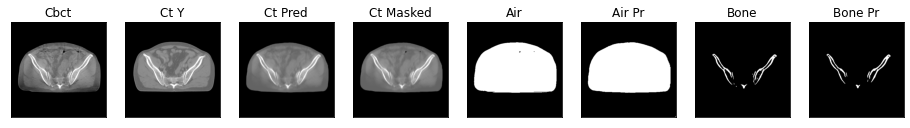

10it [00:25,  2.51s/it]

ssim score = 0.8277844786643982
psnr score = 22.913375854492188
snr score = 13.487607955932617
mae error = 0.029226740822196007
air dice score = 0.9953631616527486
bone dice score = 0.8674196351022169


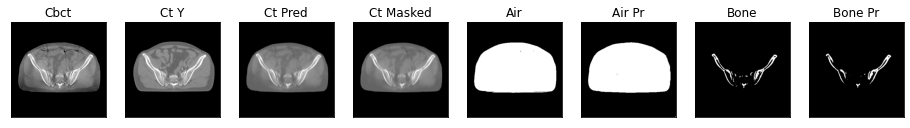

ssim score = 0.8796695470809937
psnr score = 24.519054412841797
snr score = 14.953189849853516
mae error = 0.01995166577398777
air dice score = 0.9936703317701624
bone dice score = 0.9600929872158043


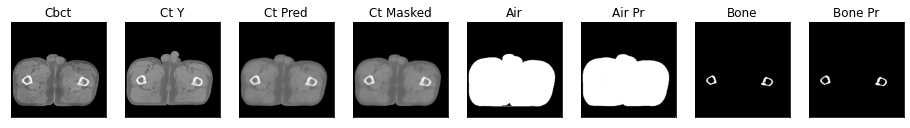

ssim score = 0.8800220489501953
psnr score = 24.844205856323242
snr score = 15.342732429504395
mae error = 0.019697483628988266
air dice score = 0.9935867528092603
bone dice score = 0.9415538132593887


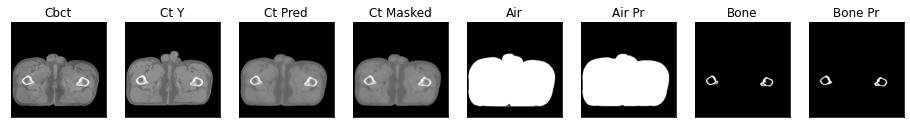

ssim score = 0.8880305886268616
psnr score = 26.56534194946289
snr score = 17.203079223632812
mae error = 0.018425781279802322
air dice score = 0.9938104690601652
bone dice score = 0.9376896149372768


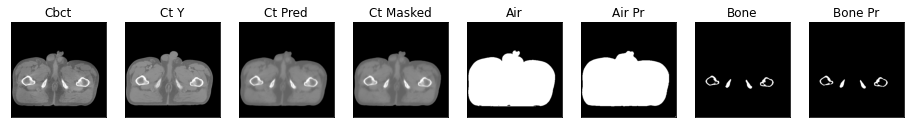

ssim score = 0.8877214789390564
psnr score = 26.454965591430664
snr score = 17.214195251464844
mae error = 0.0190296471118927
air dice score = 0.9937189054726417
bone dice score = 0.9176254026710164


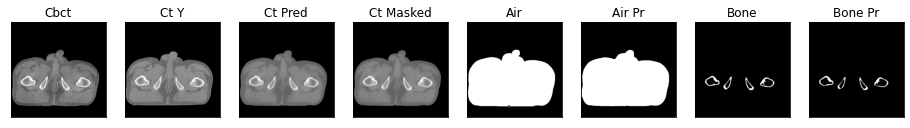

ssim score = 0.8825488686561584
psnr score = 26.186437606811523
snr score = 16.969839096069336
mae error = 0.019579794257879257
air dice score = 0.99421535025822
bone dice score = 0.8655086848668608


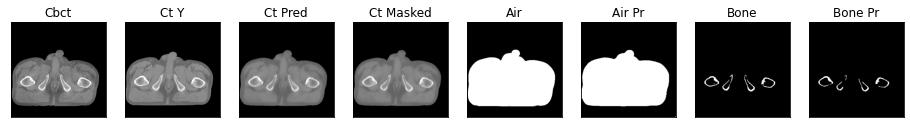

ssim score = 0.8836561441421509
psnr score = 26.096391677856445
snr score = 16.875398635864258
mae error = 0.019344095140695572
air dice score = 0.9941316464724032
bone dice score = 0.8479008947041087


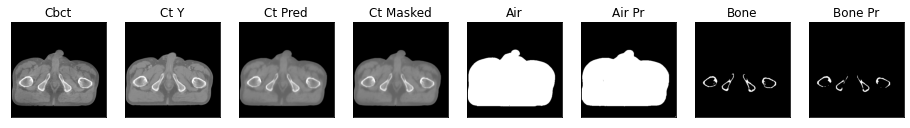

ssim score = 0.8848314881324768
psnr score = 25.575355529785156
snr score = 16.360618591308594
mae error = 0.020022796466946602
air dice score = 0.9948535110835569
bone dice score = 0.8767241379336913


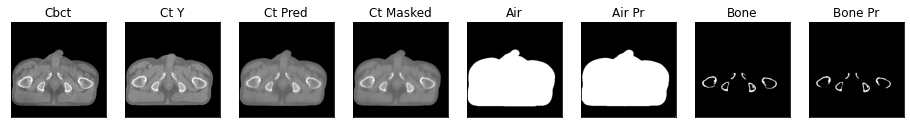

11it [00:27,  2.45s/it]

ssim score = 0.8821297287940979
psnr score = 25.226476669311523
snr score = 15.990181922912598
mae error = 0.02014651894569397
air dice score = 0.9951968216771587
bone dice score = 0.8948261238359876


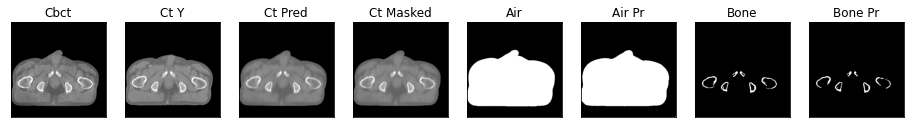

ssim score = 0.8829723596572876
psnr score = 25.24146842956543
snr score = 16.022083282470703
mae error = 0.020151475444436073
air dice score = 0.9953613623274167
bone dice score = 0.9013585351466556


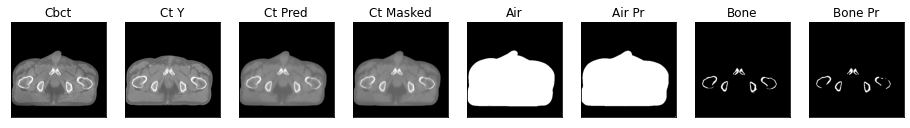

ssim score = 0.8834295868873596
psnr score = 25.50387954711914
snr score = 16.353086471557617
mae error = 0.020125657320022583
air dice score = 0.9954372148259302
bone dice score = 0.8857715430882533


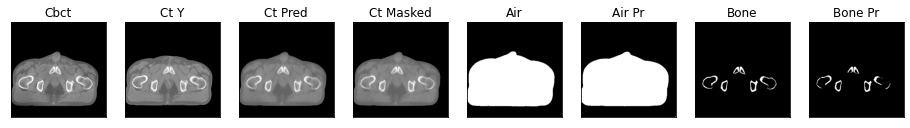

ssim score = 0.8848186135292053
psnr score = 25.947893142700195
snr score = 16.878459930419922
mae error = 0.019863033667206764
air dice score = 0.9959355972632007
bone dice score = 0.8811798223582842


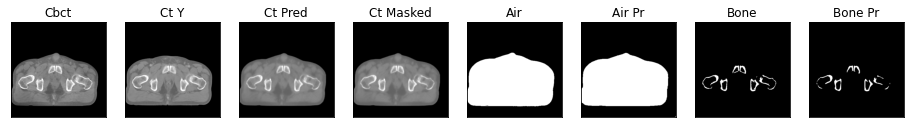

ssim score = 0.8861885666847229
psnr score = 26.324626922607422
snr score = 17.305896759033203
mae error = 0.01981077902019024
air dice score = 0.9959280757992266
bone dice score = 0.8295755968198014


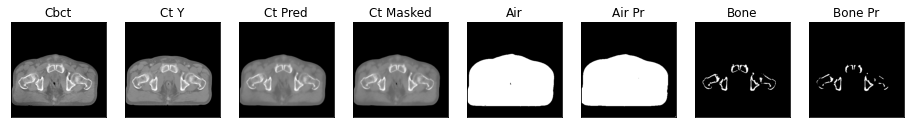

ssim score = 0.8899387717247009
psnr score = 26.69561767578125
snr score = 17.79315757751465
mae error = 0.01948441192507744
air dice score = 0.9957259217709412
bone dice score = 0.8224213884274278


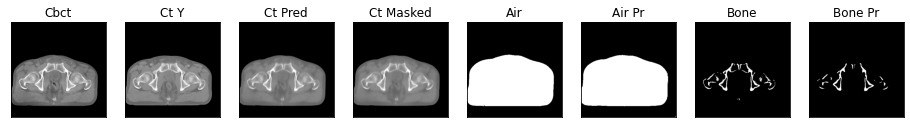

ssim score = 0.8882264494895935
psnr score = 26.696598052978516
snr score = 17.755901336669922
mae error = 0.0193734560161829
air dice score = 0.9949282896668903
bone dice score = 0.7868465430052808


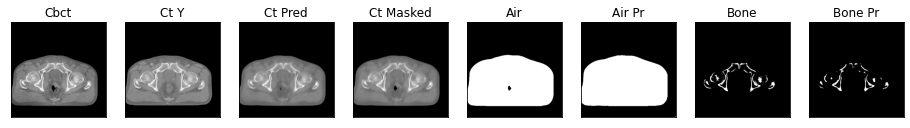

ssim score = 0.8822078108787537
psnr score = 26.56029510498047
snr score = 17.523929595947266
mae error = 0.019362324848771095
air dice score = 0.9916810898330701
bone dice score = 0.7865928659319404


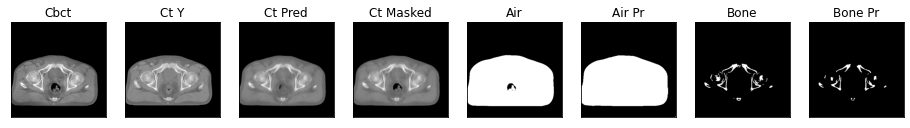

12it [00:30,  2.48s/it]

ssim score = 0.8870763182640076
psnr score = 26.769296646118164
snr score = 17.57317352294922
mae error = 0.018751444295048714
air dice score = 0.989948862634464
bone dice score = 0.7941684250950668


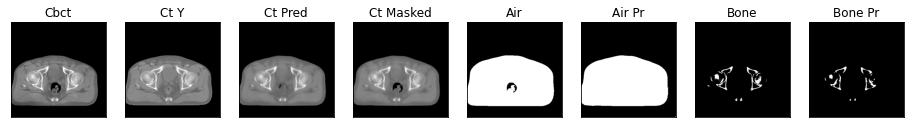

ssim score = 0.8838850855827332
psnr score = 25.219661712646484
snr score = 15.907111167907715
mae error = 0.020145250484347343
air dice score = 0.9919436789178093
bone dice score = 0.810979170725891


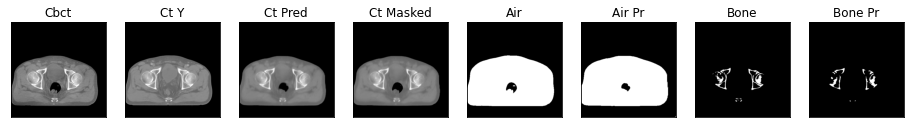

ssim score = 0.8819941282272339
psnr score = 24.903966903686523
snr score = 15.546321868896484
mae error = 0.020093653351068497
air dice score = 0.9930712530712588
bone dice score = 0.8571428571453643


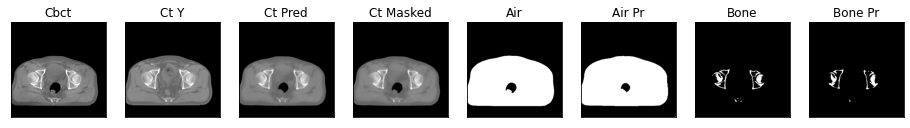

ssim score = 0.8770495653152466
psnr score = 24.33023452758789
snr score = 14.979263305664062
mae error = 0.021544083952903748
air dice score = 0.9924226271506188
bone dice score = 0.9011657374573211


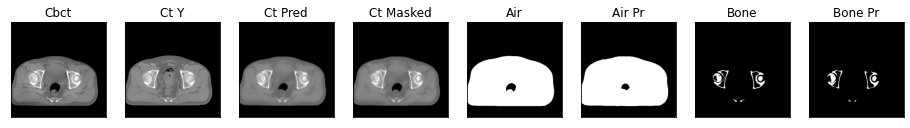

ssim score = 0.8781844973564148
psnr score = 23.8441104888916
snr score = 14.52324104309082
mae error = 0.022719919681549072
air dice score = 0.9938059867235942
bone dice score = 0.9305896805907464


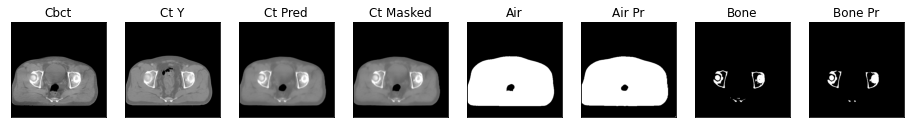

ssim score = 0.8839501738548279
psnr score = 24.73876190185547
snr score = 15.375308990478516
mae error = 0.02116372063755989
air dice score = 0.992536884539288
bone dice score = 0.9209513816033412


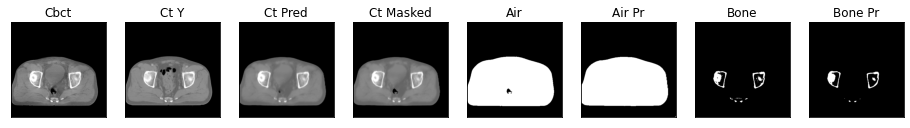

ssim score = 0.8858464956283569
psnr score = 24.744258880615234
snr score = 15.290599822998047
mae error = 0.020450923591852188
air dice score = 0.9937662552119938
bone dice score = 0.9070140280579757


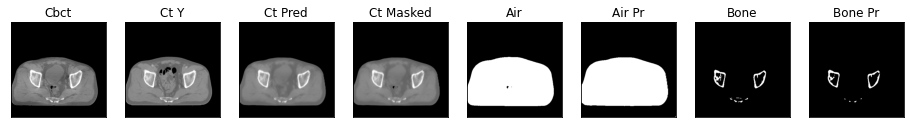

ssim score = 0.8868198990821838
psnr score = 24.820375442504883
snr score = 15.30099105834961
mae error = 0.020126398652791977
air dice score = 0.9924629183913183
bone dice score = 0.9220886862842501


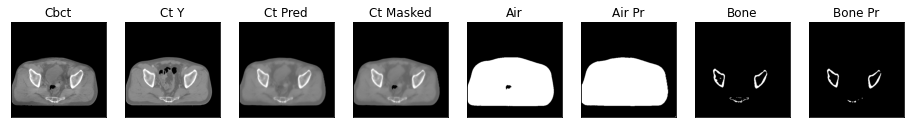

13it [00:32,  2.49s/it]

ssim score = 0.8865741491317749
psnr score = 25.065582275390625
snr score = 15.545896530151367
mae error = 0.019795680418610573
air dice score = 0.992011412268195
bone dice score = 0.9158776402054647


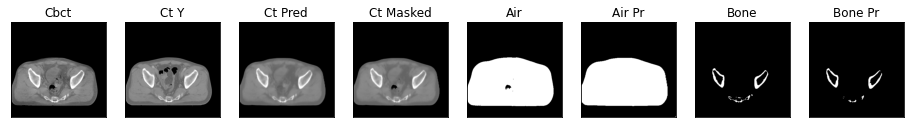

ssim score = 0.8819671869277954
psnr score = 25.16868782043457
snr score = 15.725170135498047
mae error = 0.020387127995491028
air dice score = 0.9911914774794669
bone dice score = 0.9010432190774808


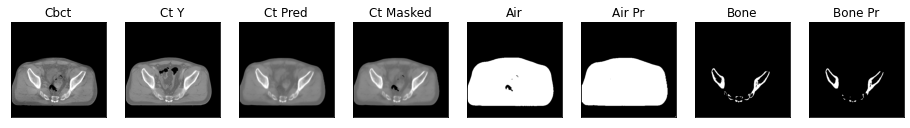

ssim score = 0.8849535584449768
psnr score = 25.228193283081055
snr score = 15.820253372192383
mae error = 0.019811533391475677
air dice score = 0.9914084074869665
bone dice score = 0.9206989247322487


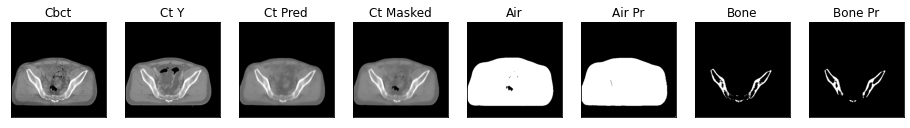

ssim score = 0.8879508972167969
psnr score = 25.525691986083984
snr score = 16.056055068969727
mae error = 0.019046546891331673
air dice score = 0.9927097449268464
bone dice score = 0.8927075812289862


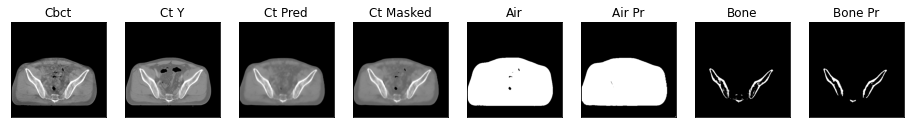

ssim score = 0.8864442110061646
psnr score = 25.256834030151367
snr score = 15.725936889648438
mae error = 0.01959259621798992
air dice score = 0.9930016695646217
bone dice score = 0.8941033064163629


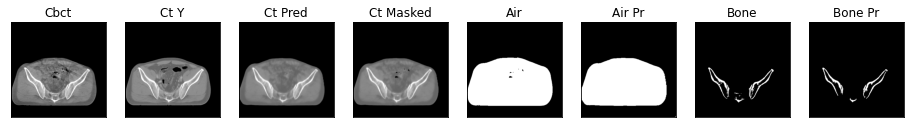

ssim score = 0.8266758322715759
psnr score = 22.744823455810547
snr score = 14.442129135131836
mae error = 0.02902400493621826
air dice score = 0.9933864075604216
bone dice score = 0.9753476611891483


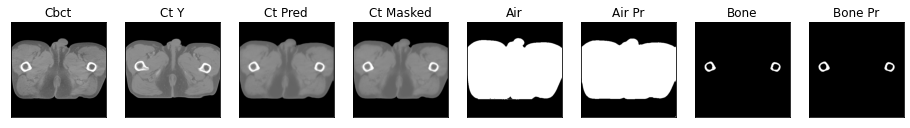

ssim score = 0.8168407678604126
psnr score = 22.341171264648438
snr score = 14.142769813537598
mae error = 0.03071550838649273
air dice score = 0.9943559955788666
bone dice score = 0.9695243520373249


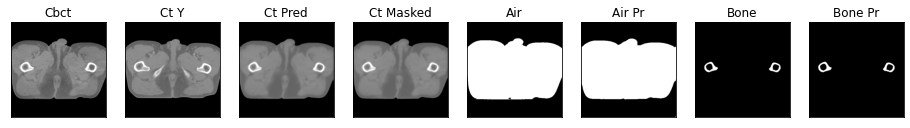

ssim score = 0.8103475570678711
psnr score = 21.993896484375
snr score = 13.923452377319336
mae error = 0.032770827412605286
air dice score = 0.9949989739981855
bone dice score = 0.9366797144845342


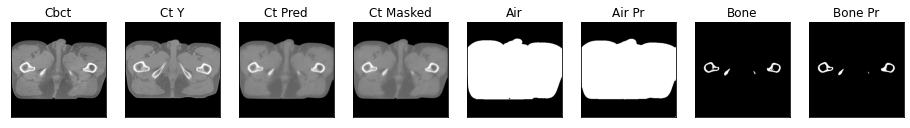

14it [00:34,  2.45s/it]

ssim score = 0.8014323711395264
psnr score = 21.741323471069336
snr score = 13.703166961669922
mae error = 0.03285863995552063
air dice score = 0.9948122890847552
bone dice score = 0.9481608212156003


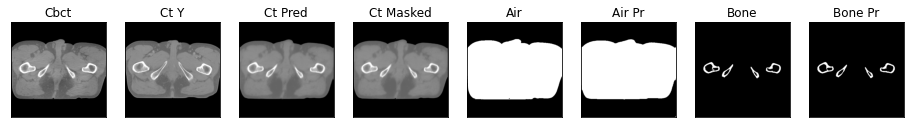

ssim score = 0.792803168296814
psnr score = 21.62921905517578
snr score = 13.621301651000977
mae error = 0.03370266780257225
air dice score = 0.9948592868354593
bone dice score = 0.9004462753192508


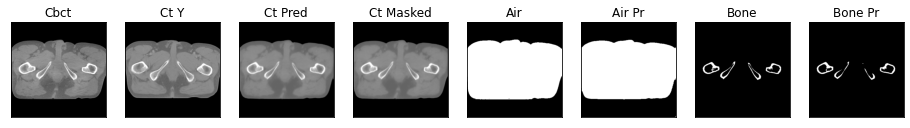

ssim score = 0.7868538498878479
psnr score = 21.511743545532227
snr score = 13.538241386413574
mae error = 0.03462432697415352
air dice score = 0.9949546970199572
bone dice score = 0.9055130915611398


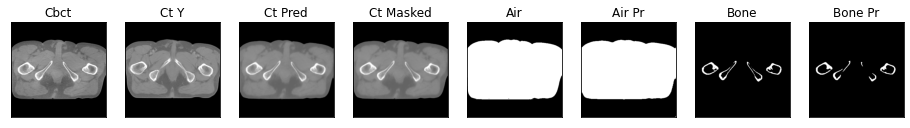

ssim score = 0.7804417014122009
psnr score = 21.264562606811523
snr score = 13.311371803283691
mae error = 0.0356818251311779
air dice score = 0.9948101199761121
bone dice score = 0.9084939329063741


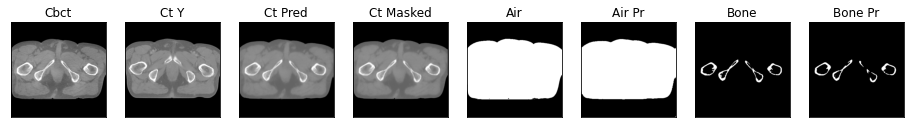

ssim score = 0.7791500091552734
psnr score = 21.28066635131836
snr score = 13.366547584533691
mae error = 0.03542216494679451
air dice score = 0.9945867708785673
bone dice score = 0.9086803105164618


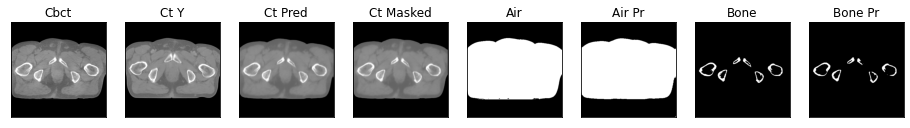

ssim score = 0.7798795700073242
psnr score = 21.439163208007812
snr score = 13.573723793029785
mae error = 0.03506745398044586
air dice score = 0.9938793827267762
bone dice score = 0.9196089082031558


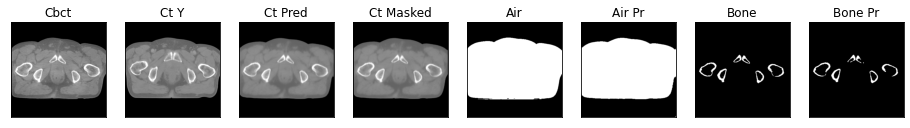

ssim score = 0.7718433141708374
psnr score = 21.241100311279297
snr score = 13.398273468017578
mae error = 0.036720097064971924
air dice score = 0.9943655127730503
bone dice score = 0.9135608735463114


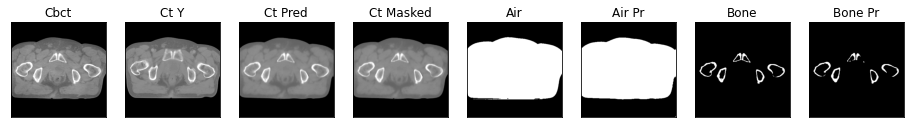

ssim score = 0.759292483329773
psnr score = 21.173669815063477
snr score = 13.373621940612793
mae error = 0.03838984668254852
air dice score = 0.9944637197568457
bone dice score = 0.8932207598721974


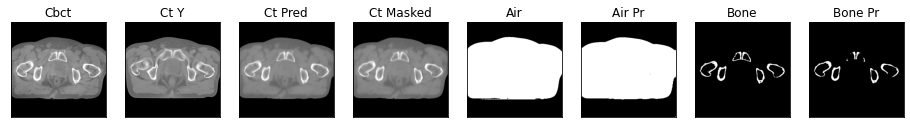

15it [00:37,  2.48s/it]

ssim score = 0.7610411643981934
psnr score = 21.28143310546875
snr score = 13.539722442626953
mae error = 0.03815286606550217
air dice score = 0.9945842038319235
bone dice score = 0.8911642890026327


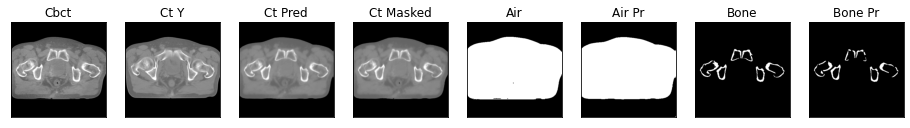

ssim score = 0.7557746767997742
psnr score = 21.08696937561035
snr score = 13.269887924194336
mae error = 0.04024403542280197
air dice score = 0.9951810277407214
bone dice score = 0.8742250709270335


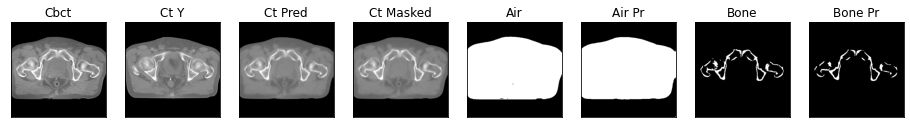

ssim score = 0.7594839334487915
psnr score = 20.93193817138672
snr score = 13.007636070251465
mae error = 0.04087498411536217
air dice score = 0.9953890556188005
bone dice score = 0.8573780613309593


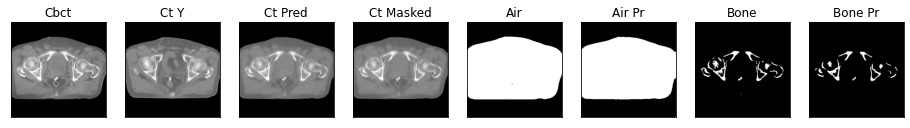

ssim score = 0.7719071507453918
psnr score = 21.175291061401367
snr score = 13.12790298461914
mae error = 0.039888035506010056
air dice score = 0.9955166241733981
bone dice score = 0.823935558114615


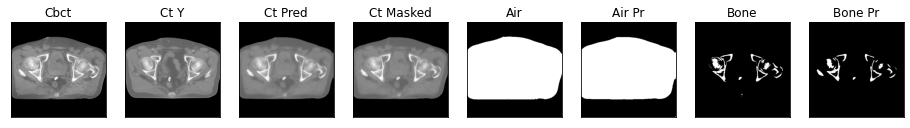

ssim score = 0.7760109901428223
psnr score = 21.43010139465332
snr score = 13.270282745361328
mae error = 0.03851956129074097
air dice score = 0.9956332381529257
bone dice score = 0.8606831160450308


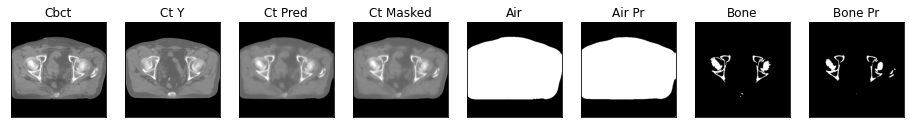

ssim score = 0.7752692103385925
psnr score = 21.767024993896484
snr score = 13.556558609008789
mae error = 0.035860009491443634
air dice score = 0.9955641406751554
bone dice score = 0.8880459520983197


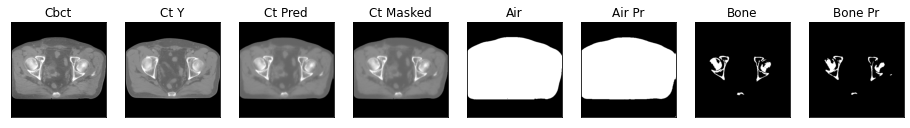

ssim score = 0.7738481163978577
psnr score = 21.57318115234375
snr score = 13.39487075805664
mae error = 0.037046048790216446
air dice score = 0.995363358344507
bone dice score = 0.8947368421064571


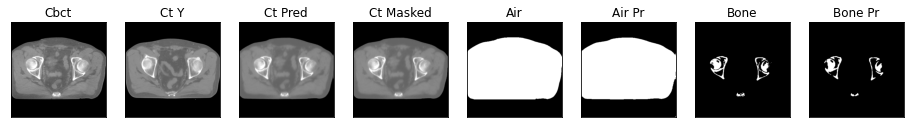

ssim score = 0.7733953595161438
psnr score = 21.387279510498047
snr score = 13.222447395324707
mae error = 0.03768822178244591
air dice score = 0.9950310197186409
bone dice score = 0.907777097367939


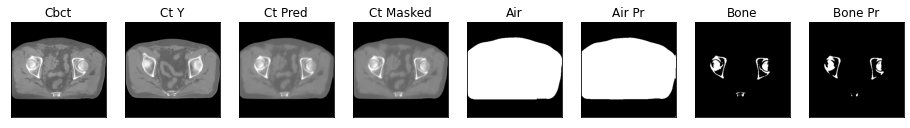

16it [00:40,  2.50s/it]

ssim score = 0.771935760974884
psnr score = 20.923736572265625
snr score = 12.617410659790039
mae error = 0.039359234273433685
air dice score = 0.99462217722823
bone dice score = 0.9250089702197701


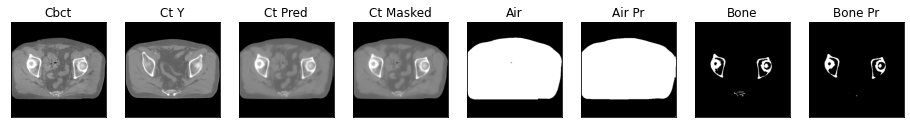

ssim score = 0.7795791029930115
psnr score = 21.01385498046875
snr score = 12.648221969604492
mae error = 0.03886155039072037
air dice score = 0.9943471585795578
bone dice score = 0.9153737658686125


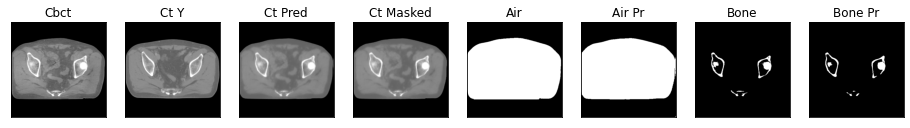

ssim score = 0.7793400883674622
psnr score = 21.416271209716797
snr score = 13.076284408569336
mae error = 0.03652326762676239
air dice score = 0.9954985064032442
bone dice score = 0.8983016983037302


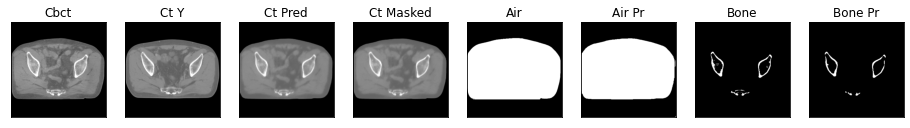

ssim score = 0.7761576175689697
psnr score = 21.34332275390625
snr score = 13.07614803314209
mae error = 0.03661433234810829
air dice score = 0.9953154909817284
bone dice score = 0.9008810572705418


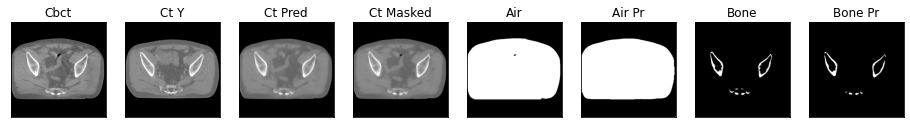

ssim score = 0.7694395184516907
psnr score = 21.106775283813477
snr score = 12.968831062316895
mae error = 0.0383317731320858
air dice score = 0.9952118788443979
bone dice score = 0.9110090182080822


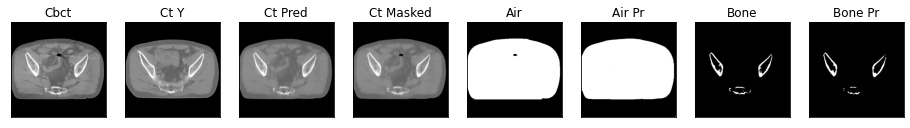

ssim score = 0.7622809410095215
psnr score = 20.972501754760742
snr score = 12.868517875671387
mae error = 0.039008788764476776
air dice score = 0.9941525388077945
bone dice score = 0.9067285382845054


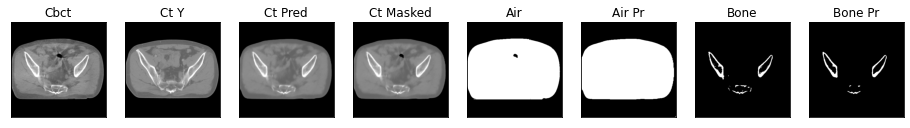

ssim score = 0.7507951855659485
psnr score = 20.77431869506836
snr score = 12.640546798706055
mae error = 0.04008602350950241
air dice score = 0.9948428424081243
bone dice score = 0.9045580458334858


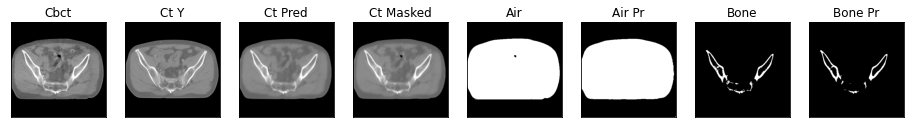

ssim score = 0.7492896914482117
psnr score = 21.011598587036133
snr score = 12.814447402954102
mae error = 0.03861227631568909
air dice score = 0.9952472921674193
bone dice score = 0.8916383412659192


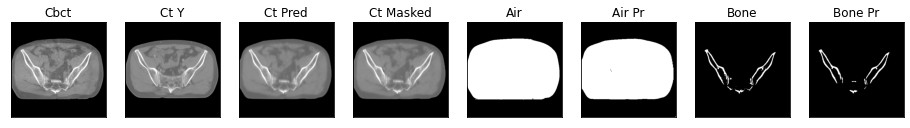

17it [00:42,  2.45s/it]

ssim score = 0.855390191078186
psnr score = 23.524124145507812
snr score = 15.00151538848877
mae error = 0.02723018452525139
air dice score = 0.9941051289086005
bone dice score = 0.87003470883314


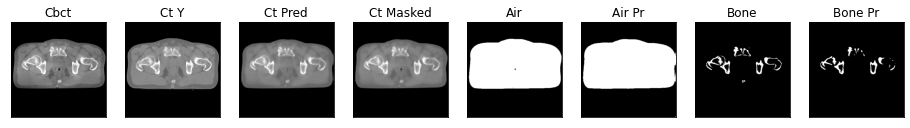

ssim score = 0.8567478656768799
psnr score = 23.682971954345703
snr score = 15.200374603271484
mae error = 0.02657022327184677
air dice score = 0.9934789067142057
bone dice score = 0.860449468444887


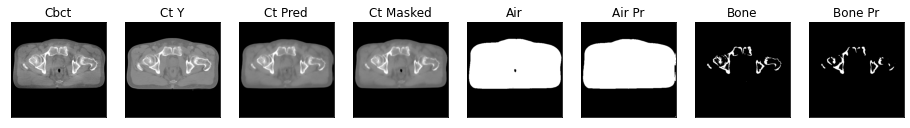

ssim score = 0.8556956052780151
psnr score = 23.731157302856445
snr score = 15.25634765625
mae error = 0.027193451300263405
air dice score = 0.9940601419916039
bone dice score = 0.8276653752356483


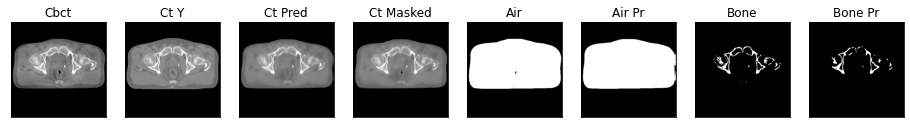

ssim score = 0.8594055771827698
psnr score = 23.84716796875
snr score = 15.313939094543457
mae error = 0.02622339129447937
air dice score = 0.9937401257936673
bone dice score = 0.8469873150125926


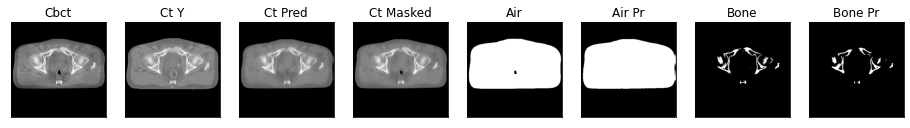

ssim score = 0.8638418912887573
psnr score = 24.085390090942383
snr score = 15.396537780761719
mae error = 0.02412443235516548
air dice score = 0.9936742934051191
bone dice score = 0.8536204744092756


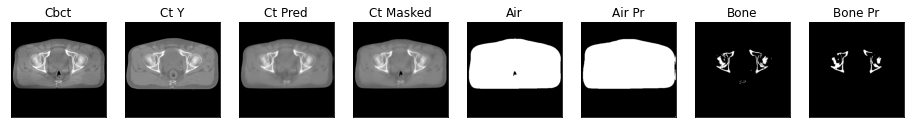

ssim score = 0.8671912550926208
psnr score = 24.16412353515625
snr score = 15.45446491241455
mae error = 0.023691629990935326
air dice score = 0.994402761104446
bone dice score = 0.8692296274325482


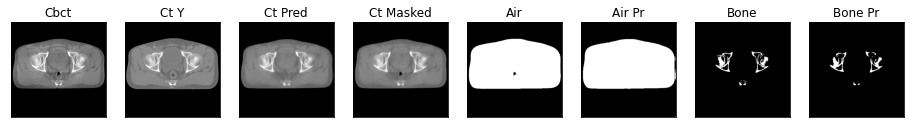

ssim score = 0.8691970705986023
psnr score = 24.25213623046875
snr score = 15.526848793029785
mae error = 0.02358209155499935
air dice score = 0.9947454003432844
bone dice score = 0.8924978442096508


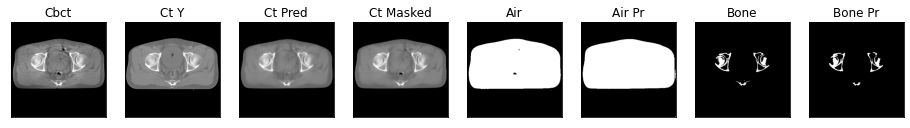

ssim score = 0.8648830056190491
psnr score = 23.83083152770996
snr score = 15.114906311035156
mae error = 0.024442048743367195
air dice score = 0.9949303010842092
bone dice score = 0.8941007194259841


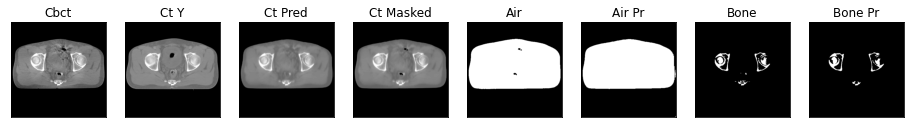

18it [00:44,  2.47s/it]

ssim score = 0.8631443977355957
psnr score = 23.820999145507812
snr score = 15.160857200622559
mae error = 0.025048404932022095
air dice score = 0.9955023169882216
bone dice score = 0.9202200825320465


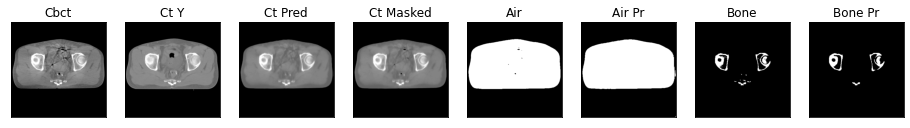

ssim score = 0.8610532283782959
psnr score = 23.45207977294922
snr score = 14.770008087158203
mae error = 0.02553355135023594
air dice score = 0.9948011674571364
bone dice score = 0.9279253815725279


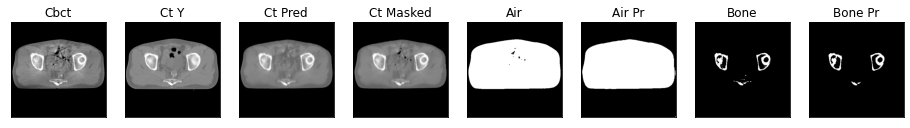

ssim score = 0.8609399795532227
psnr score = 23.019121170043945
snr score = 14.266275405883789
mae error = 0.026031669229269028
air dice score = 0.9943098608738145
bone dice score = 0.9004061738440227


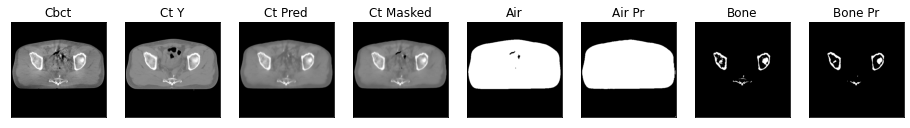

ssim score = 0.8606929779052734
psnr score = 23.1991024017334
snr score = 14.402364730834961
mae error = 0.025571685284376144
air dice score = 0.9952620397683021
bone dice score = 0.8874309392284628


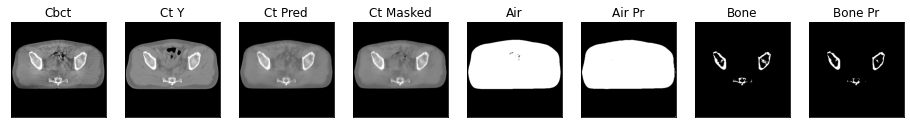

ssim score = 0.8620406985282898
psnr score = 23.444778442382812
snr score = 14.646944046020508
mae error = 0.02523457631468773
air dice score = 0.9944482785062537
bone dice score = 0.9055352999684201


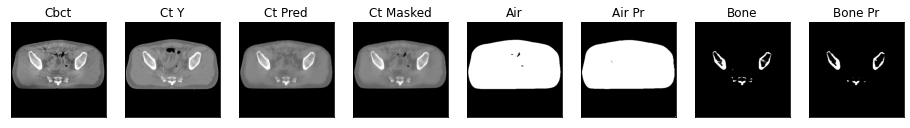

ssim score = 0.8591116070747375
psnr score = 23.825237274169922
snr score = 15.04075813293457
mae error = 0.024552350863814354
air dice score = 0.9935978331127507
bone dice score = 0.9111738857515509


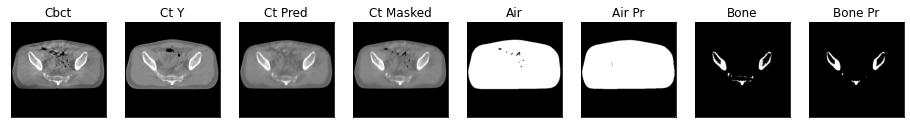

ssim score = 0.8569847941398621
psnr score = 24.03412628173828
snr score = 15.304851531982422
mae error = 0.02428872138261795
air dice score = 0.9923804377195411
bone dice score = 0.9181355268322479


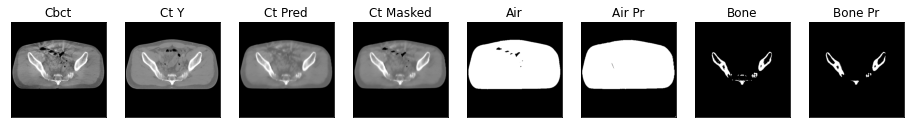

ssim score = 0.8588417172431946
psnr score = 23.678394317626953
snr score = 14.968489646911621
mae error = 0.024779165163636208
air dice score = 0.9930960903615909
bone dice score = 0.9071504802573752


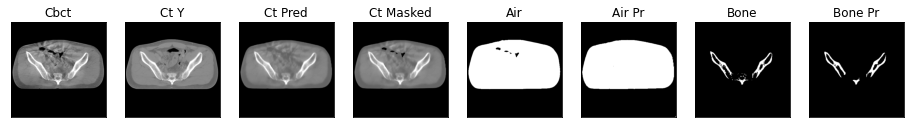

19it [00:47,  2.49s/it]

ssim score = 0.8612872958183289
psnr score = 23.298770904541016
snr score = 14.534128189086914
mae error = 0.025134917348623276
air dice score = 0.9935008665511316
bone dice score = 0.8982124390619263


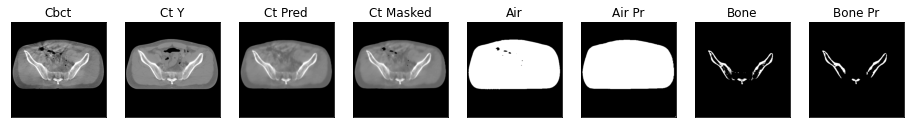

ssim score = 0.8612274527549744
psnr score = 23.248891830444336
snr score = 14.447897911071777
mae error = 0.02519098110496998
air dice score = 0.9949143489670053
bone dice score = 0.8804412641639767


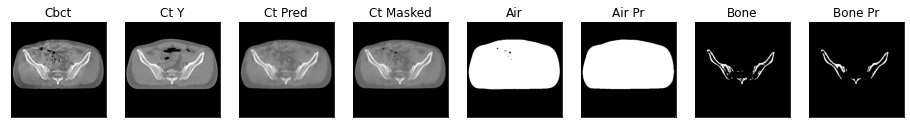

ssim score = 0.8650952577590942
psnr score = 23.33794593811035
snr score = 14.537023544311523
mae error = 0.024850351735949516
air dice score = 0.9948081334077283
bone dice score = 0.8786745056135933


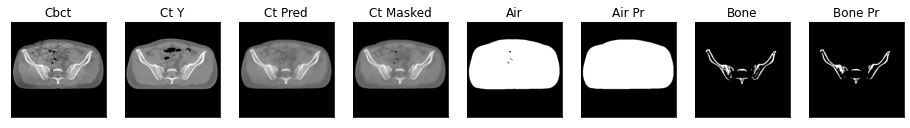

ssim score = 0.8660776019096375
psnr score = 23.73151969909668
snr score = 14.92917537689209
mae error = 0.024402111768722534
air dice score = 0.9941638468941156
bone dice score = 0.8700657894754651


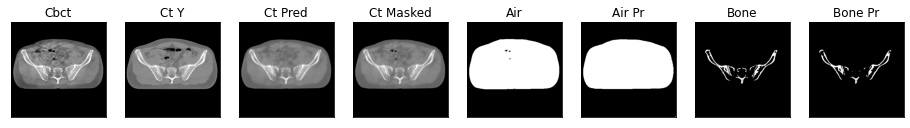

ssim score = 0.8600561618804932
psnr score = 23.54036521911621
snr score = 14.743057250976562
mae error = 0.025163697078824043
air dice score = 0.9935206863561106
bone dice score = 0.858986951033268


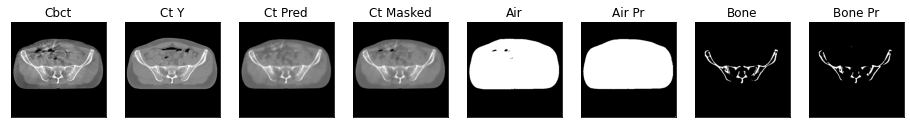

ssim score = 0.8573765754699707
psnr score = 23.311025619506836
snr score = 14.496445655822754
mae error = 0.025822767987847328
air dice score = 0.9922791365111115
bone dice score = 0.8480273465339976


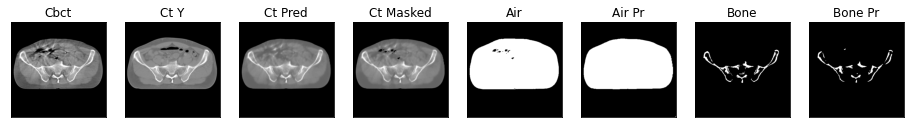

ssim score = 0.8525978326797485
psnr score = 22.881088256835938
snr score = 14.04788589477539
mae error = 0.026964642107486725
air dice score = 0.9918786968359842
bone dice score = 0.847753185783397


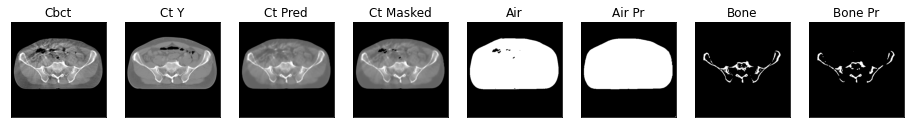

ssim score = 0.8428484797477722
psnr score = 22.44689178466797
snr score = 13.567750930786133
mae error = 0.02807711996138096
air dice score = 0.9911711386484456
bone dice score = 0.8297872340447887


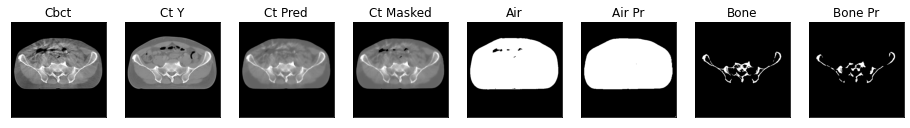

20it [00:49,  2.44s/it]

ssim score = 0.8393001556396484
psnr score = 22.614124298095703
snr score = 13.681182861328125
mae error = 0.027989115566015244
air dice score = 0.9903831764659627
bone dice score = 0.848723485331529


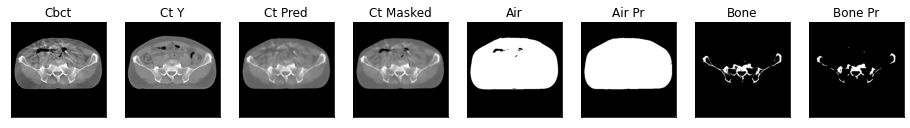

ssim score = 0.832258939743042
psnr score = 22.272384643554688
snr score = 13.369908332824707
mae error = 0.029328498989343643
air dice score = 0.9892597188085407
bone dice score = 0.8651862638045723


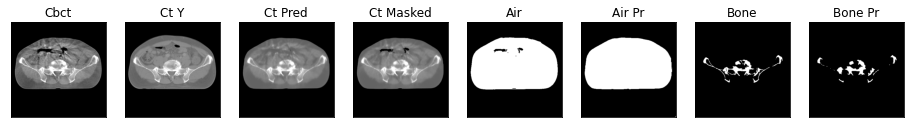

ssim score = 0.827808678150177
psnr score = 21.807783126831055
snr score = 12.850078582763672
mae error = 0.02997579239308834
air dice score = 0.9893043891617895
bone dice score = 0.8532484076451815


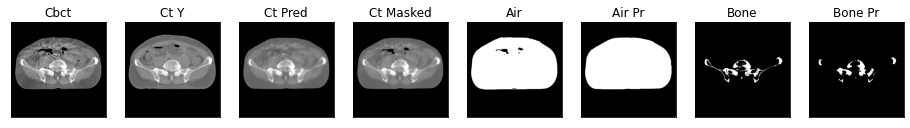

ssim score = 0.8360685706138611
psnr score = 22.402009963989258
snr score = 13.296775817871094
mae error = 0.027771571651101112
air dice score = 0.9898156974896808
bone dice score = 0.8706540562159231


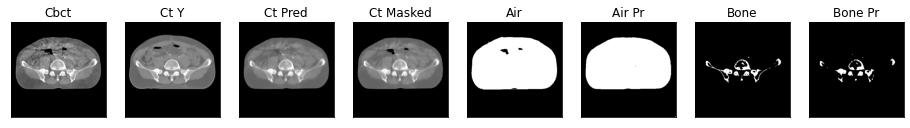

ssim score = 0.8817832469940186
psnr score = 26.341251373291016
snr score = 16.722166061401367
mae error = 0.01652652956545353
air dice score = 0.9937393872277639
bone dice score = 0.9362758620707234


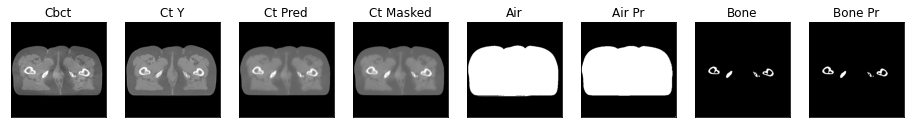

ssim score = 0.8819770216941833
psnr score = 26.489465713500977
snr score = 16.991390228271484
mae error = 0.016700565814971924
air dice score = 0.9938183338099787
bone dice score = 0.9442622950832725


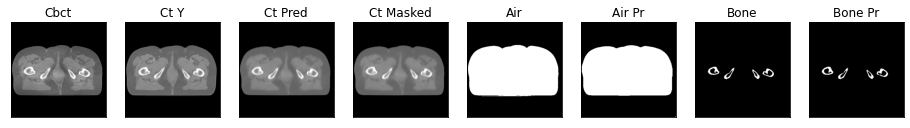

ssim score = 0.8779968619346619
psnr score = 26.3563175201416
snr score = 16.941158294677734
mae error = 0.017154458910226822
air dice score = 0.9936534075590804
bone dice score = 0.9195947402474759


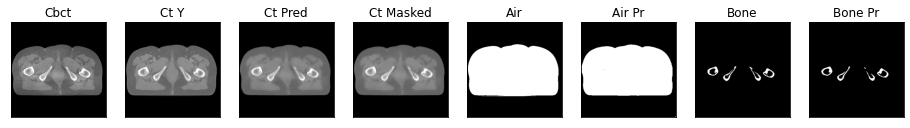

ssim score = 0.874398946762085
psnr score = 26.290943145751953
snr score = 16.93922996520996
mae error = 0.017561128363013268
air dice score = 0.9937188116513913
bone dice score = 0.9175058094516362


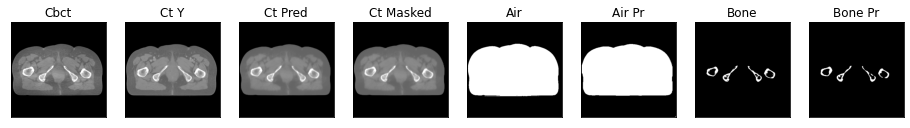

21it [00:52,  2.46s/it]

ssim score = 0.8738468289375305
psnr score = 26.125917434692383
snr score = 16.802663803100586
mae error = 0.017857881262898445
air dice score = 0.9936343470689863
bone dice score = 0.9253240825282942


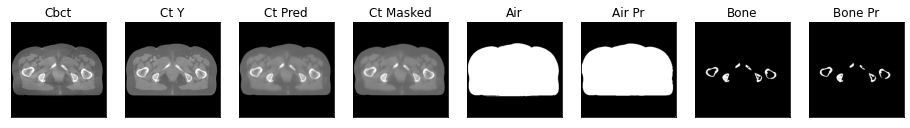

ssim score = 0.8743362426757812
psnr score = 25.983318328857422
snr score = 16.683021545410156
mae error = 0.017940891906619072
air dice score = 0.9936507707719296
bone dice score = 0.923838537701374


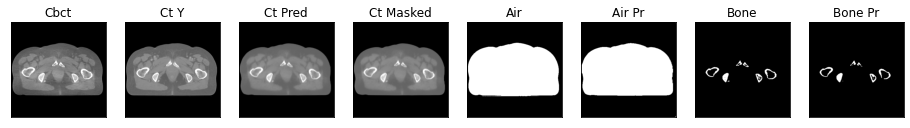

ssim score = 0.8719249367713928
psnr score = 25.9260196685791
snr score = 16.65704917907715
mae error = 0.01823020912706852
air dice score = 0.993234547663731
bone dice score = 0.9175854980392901


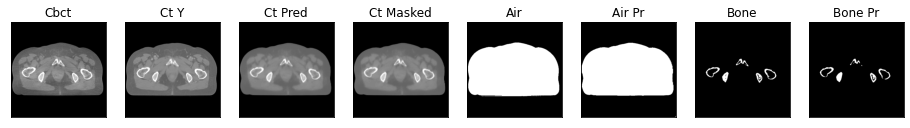

ssim score = 0.871714174747467
psnr score = 25.839576721191406
snr score = 16.61897087097168
mae error = 0.018817991018295288
air dice score = 0.9929437437638682
bone dice score = 0.9076066790369646


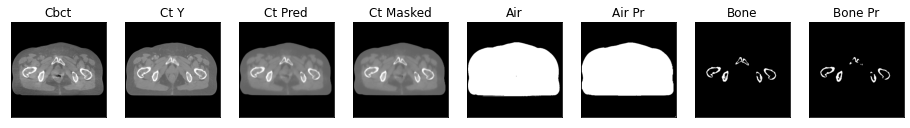

ssim score = 0.871929943561554
psnr score = 25.814720153808594
snr score = 16.636856079101562
mae error = 0.01868019439280033
air dice score = 0.9920276699412358
bone dice score = 0.9166092350117745


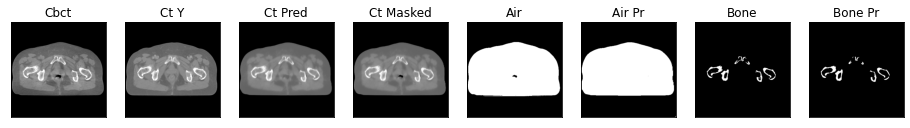

ssim score = 0.871343731880188
psnr score = 26.068613052368164
snr score = 16.978452682495117
mae error = 0.018526965752243996
air dice score = 0.9917294904993209
bone dice score = 0.8897649734664175


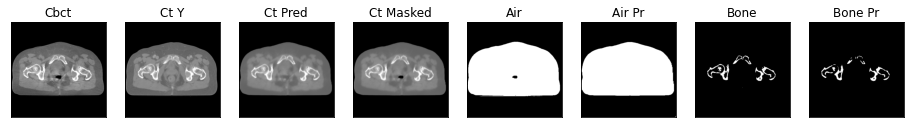

ssim score = 0.8722949624061584
psnr score = 26.32833480834961
snr score = 17.35144805908203
mae error = 0.01852458156645298
air dice score = 0.9928938074607924
bone dice score = 0.8983428147427858


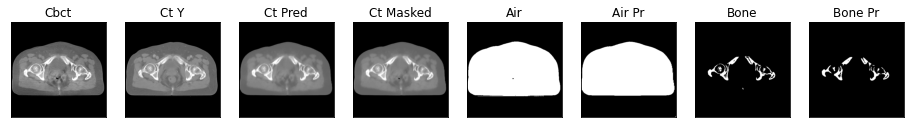

ssim score = 0.8752092123031616
psnr score = 26.56704330444336
snr score = 17.461606979370117
mae error = 0.018073132261633873
air dice score = 0.9908502151629156
bone dice score = 0.8665461121181456


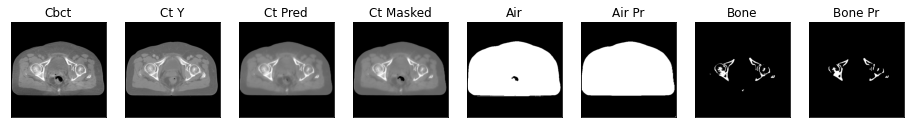

22it [00:54,  2.48s/it]

ssim score = 0.875807523727417
psnr score = 26.82992935180664
snr score = 17.615068435668945
mae error = 0.017620500177145004
air dice score = 0.9904053455931764
bone dice score = 0.8612228479513029


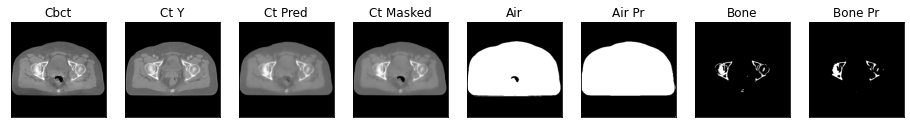

ssim score = 0.8783642649650574
psnr score = 26.712669372558594
snr score = 17.470680236816406
mae error = 0.018175838515162468
air dice score = 0.9908019136575985
bone dice score = 0.8902373728379397


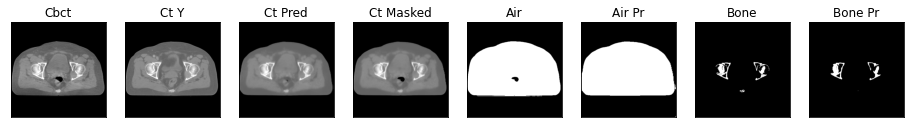

ssim score = 0.8800336718559265
psnr score = 26.537370681762695
snr score = 17.287376403808594
mae error = 0.018893225118517876
air dice score = 0.9925469176483952
bone dice score = 0.9001876812847605


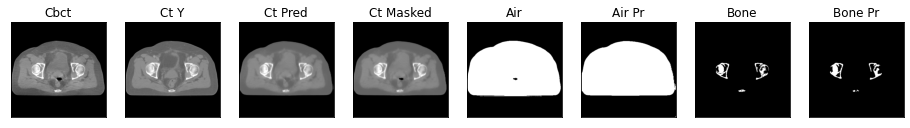

ssim score = 0.8781428337097168
psnr score = 26.659011840820312
snr score = 17.443248748779297
mae error = 0.018062999472022057
air dice score = 0.9931999522803716
bone dice score = 0.9229799968511108


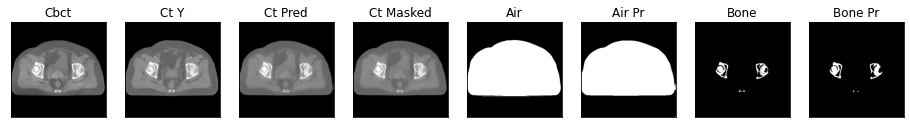

ssim score = 0.8736191987991333
psnr score = 26.240217208862305
snr score = 17.075944900512695
mae error = 0.01838379167020321
air dice score = 0.9937947028630769
bone dice score = 0.9459927570469848


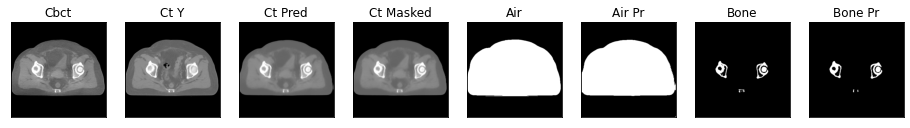

ssim score = 0.8619213104248047
psnr score = 25.244857788085938
snr score = 16.118144989013672
mae error = 0.020060978829860687
air dice score = 0.9940620857269152
bone dice score = 0.9382930644891657


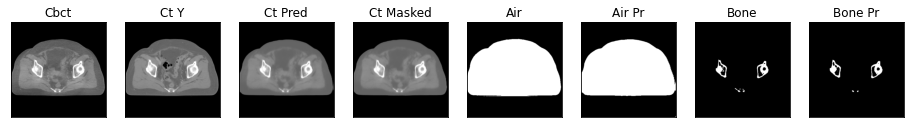

ssim score = 0.8501009941101074
psnr score = 23.970172882080078
snr score = 14.771023750305176
mae error = 0.02250850386917591
air dice score = 0.9932563345953505
bone dice score = 0.9329710144942714


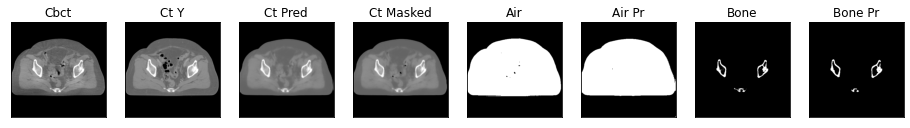

ssim score = 0.8461818099021912
psnr score = 23.89442253112793
snr score = 14.67728042602539
mae error = 0.02315361797809601
air dice score = 0.9921319762464552
bone dice score = 0.9301682415319159


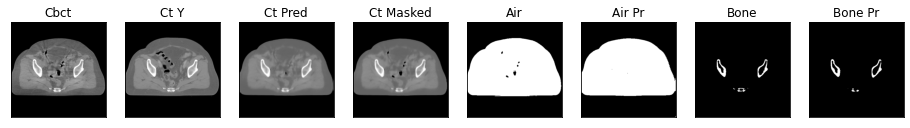

23it [00:57,  2.44s/it]

ssim score = 0.8455523252487183
psnr score = 24.26988983154297
snr score = 15.11766242980957
mae error = 0.02273065596818924
air dice score = 0.9928381998573073
bone dice score = 0.9328063241121474


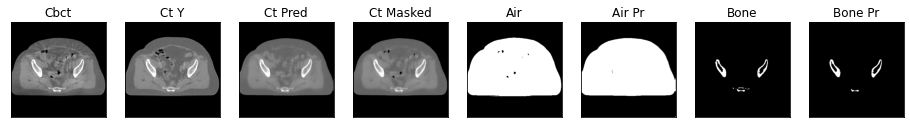

ssim score = 0.8451557755470276
psnr score = 24.089401245117188
snr score = 14.992266654968262
mae error = 0.023301811888813972
air dice score = 0.9932769522183434
bone dice score = 0.9291721173625646


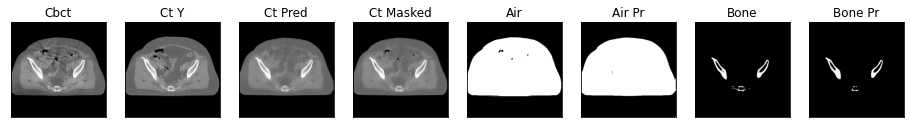

ssim score = 0.8417919278144836
psnr score = 23.696184158325195
snr score = 14.66347885131836
mae error = 0.024303795769810677
air dice score = 0.9931272386037766
bone dice score = 0.9302036374952557


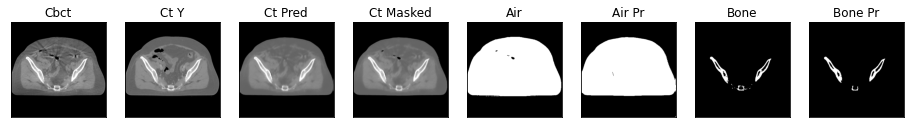

ssim score = 0.8432164788246155
psnr score = 23.801158905029297
snr score = 14.841314315795898
mae error = 0.024521097540855408
air dice score = 0.9930677499672435
bone dice score = 0.9031684927464737


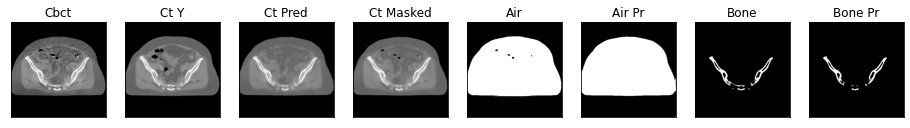

ssim score = 0.8416365385055542
psnr score = 23.979185104370117
snr score = 15.01504898071289
mae error = 0.024256641045212746
air dice score = 0.9930818549722994
bone dice score = 0.9001787842684718


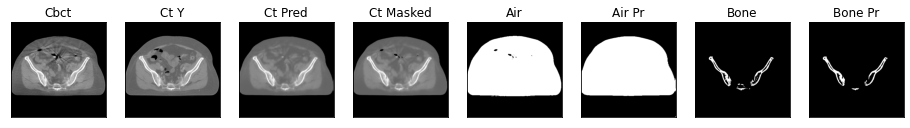

ssim score = 0.8393781781196594
psnr score = 23.725688934326172
snr score = 14.739374160766602
mae error = 0.024655921384692192
air dice score = 0.9935790510906638
bone dice score = 0.8976016085035531


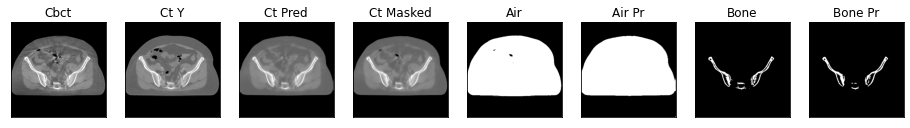

ssim score = 0.8444215059280396
psnr score = 24.16814613342285
snr score = 15.193466186523438
mae error = 0.023596826940774918
air dice score = 0.9939448134900396
bone dice score = 0.9054696789550316


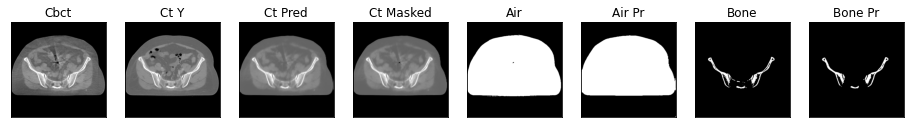

24it [00:59,  2.48s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.25it/s]


(0.8555998106797537,
 24.161930799484253,
 15.176501353581747,
 0.02454947594863673,
 0.993749116472006,
 0.9051316665072225,
 0.5)

In [38]:
# import torchvision.models as models
# models.vgg16(pretrained=True)